## IMPORTS

In [1]:
import tensorflow as tf
import os
from glob import glob
!pip install -q tensorflow-io
import tensorflow_io as tfio


from matplotlib import pyplot as plt

from IPython import display
import imageio

import numpy as np
import math
import tensorflow.keras.preprocessing.image as prep


from copy import copy
import matplotlib.colors as colors

## HYPERPARAMETERS

## Read dataset from train and validation tfrecords

In [2]:
# paths for the tfrecords
# # # for train
# train_positive =  "E:\\dataset\\Leisang\\myTry\\BleedingDataDCM/train_positive_samples_win.tfrecords"
# train_negative =  'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM/train_negative_samples_win.tfrecords'

# # for val
# val_positive =  "E:\\dataset\\Leisang\\myTry\\BleedingDataDCM/val_positive_samples_win.tfrecords"
# val_negative =  'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM/val_negative_samples_win.tfrecords'

# for ubuntu

# # for train
train_positive =  "/media/ytx/Japan_Deep_Data/dataset/LeiSang/myTry/BleedingDataDCM/train_positive_samples_unbuntu.tfrecords"
train_negative =  '/media/ytx/Japan_Deep_Data/dataset/LeiSang/myTry/BleedingDataDCM/train_negative_samples_unbuntu.tfrecords'

# for val
val_positive =  "/media/ytx/Japan_Deep_Data/dataset/LeiSang/myTry/BleedingDataDCM/val_positive_samples_unbuntu.tfrecords"
val_negative =  '/media/ytx/Japan_Deep_Data/dataset/LeiSang/myTry/BleedingDataDCM/val_negative_samples_unbuntu.tfrecords'

train_positive_dataset = tf.data.TFRecordDataset(train_positive)
train_negative_dataset = tf.data.TFRecordDataset(train_negative)

val_positive_dataset = tf.data.TFRecordDataset(val_positive)
val_negative_dataset = tf.data.TFRecordDataset(val_negative)



## PREPROCESSING

In [3]:
BUFFER_SIZE = 400
BATCH_SIZE = 2
IMG_WIDTH = 256
IMG_HEIGHT = 256

# project_name
project_name = "5_100LoadModelSegCls256_DropDisplayConfuRandFlipScrach/"
if not os.path.exists(project_name):
    os.makedirs(project_name)
# tb_log_name 
log_dir=project_name + "AE_logs/"

# image_save name
train_save_figure_path = project_name + "AE_saves/train"
test_save_figure_path = project_name + "AE_saves/test"

# training_checkpoint name
checkpoint_dir = project_name + "training_checkpoints"

# model architecture name
encoder_path = project_name + "Encoder.png"
decoder_path = project_name +"Decoder.png"
autoencoder_path = project_name + "Autoencoder.png"
new_model_path = project_name + "new_model.png"
base_model_path = project_name + "base_model.png"
classifier_path = project_name + "classifier.png"
# gif save name
anim_file = project_name + 'AE_saves.gif'

# # dicom root 
# dicom_root = 'E:/dataset/Leisang/myTry/BleedingDataDCM'

In [4]:
import math as m
# import tensorflow_addons as tfa

def resize(input, target):
    print(input.shape)
    print(target.shape)
    resized_input = tf.image.resize(input, [IMG_HEIGHT, IMG_WIDTH],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    resized_target = tf.image.resize(target, [IMG_HEIGHT, IMG_WIDTH],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    resized_input =  tf.reshape(resized_input, [IMG_HEIGHT, IMG_WIDTH, 1])
    resized_target =  tf.reshape(resized_target, [IMG_HEIGHT, IMG_WIDTH, 1])
    return  resized_input, resized_target

# @tf.function()
def truncate(x, min, max):
#     print(x.shape)
    cliped =  tf.clip_by_value(x, min, max)
    return cliped
 
def norm(x, min, max):
    # normalize_value = (value − min_value) / (max_value − min_value)
    tensor = tf.math.divide(tf.subtract(x, min),
                    tf.subtract(max, min))
    return tensor

def linear_normalization(input, min=30720.0, max=34816.0):
    truncated_input = truncate(input, min, max)
    norm_input = norm(truncated_input, min, max )
    return  norm_input


def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 1])  # crop to 256x256

    return cropped_image[0], cropped_image[1]

@tf.function()
def random_jitter(input_image, real_image):
    # randomly cropping to 256 x 256 x 3
#     input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

# @tf.function()
# def Random_RotateInRnage(image, range_min=0, range_max = 30):
    
#     if tf.random.uniform(()) > 0.5: # rotate
#         # angle
#         PI = tf.constant(m.pi)
# #         rotate_angel = random.random()/180*PI*angel
#         angle = tf.random.uniform([], minval=range_min, maxval=range_max)
# #         image = prep.random_rotation(image, rg=rotate_rg, 
# #                                      row_axis=0, col_axis=1, channel_axis=2)
#         img =  tfa.image.rotate(image, angle)
#     return img

# def winwise(input,LB,HB):
#         # 20 ,380 for range (-32768, 32767)
#         # for tf input , (0, 65535)-? LB =  32788, 33148
#         input[input<LB] = LB # low boundary , if < LW , set to LW
#         input[input>HB] = HB # high boundary, if > Hw, Set to 255
#         return input

In [5]:
# parser the dataset to decode the features
# Create a dictionary describing the features.
image_feature_description = {
        'dicom_path': tf.io.FixedLenFeature([], tf.string),
        'seg_label': tf.io.FixedLenFeature([], tf.string), 
        'cls_label': tf.io.FixedLenFeature([], tf.int64),
}

@tf.function()
def train__parse_image_function(example_proto):
    # extract features # Parse the input tf.Example proto using the dictionary above.
    parsed_features = tf.io.parse_single_example(example_proto, image_feature_description)
       
    # decode dicom
    dicom_path = parsed_features["dicom_path"]
    image_bytes = tf.io.read_file(dicom_path)
    input_image = tf.cast(tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16), tf.float32)
    # decode mask
    seg_label = tf.cast(tf.io.decode_raw(parsed_features['seg_label'], tf.uint8), tf.float32)
    # reshape
    seg_label = tf.reshape(seg_label, [-1, 512,512,1])
    
    
    # preprocessing--->
    # 1st resize
    input_image, seg_label = resize(input_image, seg_label)
    print(input_image.shape)
    print(seg_label.shape)
    
    # 2nd random flip
    input_image, seg_label = random_jitter(input_image, seg_label)
    print(input_image.shape)
    print(seg_label.shape)
    
    # Last normalize
    input_image2 = linear_normalization(input_image) 
    seg_label =  seg_label/255.0
    
#     # 3nd random rotate
#     rinput_imag2 = Random_RotateInRnage(input_image2)
#     seg_label = Random_RotateInRnage(seg_label)
    
    #lei -window
    input_w_image = linear_normalization(input_image,min=32788.0, max=33148.0)
  
    
#     print("range of cliped_input: [{}, {}]".format(np.min(input_image), np.max(input_image)))
#     print("range of cliped_target: [{}, {}]".format(np.min(seg_label), np.max(seg_label)))
    
    
    return dicom_path, input_w_image ,input_image2, seg_label,  parsed_features["cls_label"]

@tf.function()
def test__parse_image_function(example_proto):
    # extract features # Parse the input tf.Example proto using the dictionary above.
    parsed_features = tf.io.parse_single_example(example_proto, image_feature_description)
       
    # decode dicom
    dicom_path = parsed_features["dicom_path"]
    image_bytes = tf.io.read_file(dicom_path)
    input_image = tf.cast(tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16), tf.float32)
    # decode mask
    seg_label = tf.cast(tf.io.decode_raw(parsed_features['seg_label'], tf.uint8), tf.float32)
    # reshape
    seg_label = tf.reshape(seg_label, [-1, 512,512,1])
    
    
    # preprocessing--->
    # 1st resize
    input_image, seg_label = resize(input_image, seg_label)
    print(input_image.shape)
    print(seg_label.shape)
    
#     # 2nd random flip
#     input_image, seg_label = random_jitter(input_image, seg_label)
#     print(input_image.shape)
#     print(seg_label.shape)
    
    # Last normalize
    input_image2 = linear_normalization(input_image) 
    seg_label =  seg_label/255.0
    
#     # 3nd random rotate
#     rinput_imag2 = Random_RotateInRnage(input_image2)
#     seg_label = Random_RotateInRnage(seg_label)
    
    #lei -window
    input_w_image = linear_normalization(input_image,min=32788.0, max=33148.0)
  
    
#     print("range of cliped_input: [{}, {}]".format(np.min(input_image), np.max(input_image)))
#     print("range of cliped_target: [{}, {}]".format(np.min(seg_label), np.max(seg_label)))
    
    
    return dicom_path, input_w_image ,input_image2, seg_label,  parsed_features["cls_label"]


# train: positive
train_nb_pos = 3035
train_nb_neg = 33588
parsed_train_positive_dataset = train_positive_dataset.map(train__parse_image_function)
parsed_train_negative_dataset = train_negative_dataset.map(train__parse_image_function)

val_nb_pos = 238
val_nb_neg = 4420
parsed_val_positive_dataset = val_positive_dataset.map(test__parse_image_function)
parsed_val_negative_dataset = val_negative_dataset.map(test__parse_image_function)

(None, None, None, None)
(None, 512, 512, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(None, None, None, None)
(None, 512, 512, 1)
(256, 256, 1)
(256, 256, 1)


dicom_path: tf.Tensor(b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\train/ZA-006_000/00001164.DCM', shape=(), dtype=string)
input_image.shape (256, 256, 1)
seg_label (256, 256, 1)
cls_label tf.Tensor(1, shape=(), dtype=int64)
masked_in range:[0.0, 1.532958984375]
masked range:[1.5166015625, 1.532958984375]
tf.Tensor(b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\train/ZA-006_000/00001164.DCM', shape=(), dtype=string)
dicom_path: tf.Tensor(b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\train/ZA-006_000/00001165.DCM', shape=(), dtype=string)
input_image.shape (256, 256, 1)
seg_label (256, 256, 1)
cls_label tf.Tensor(1, shape=(), dtype=int64)
masked_in range:[0.0, 1.5380859375]


E:\Projects\Intepreters\Anaconda\envs\TF21\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 65306 missing from current font.
  font.set_text(s, 0.0, flags=flags)


masked range:[1.5068359375, 1.5380859375]
tf.Tensor(b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\train/ZA-006_000/00001165.DCM', shape=(), dtype=string)


E:\Projects\Intepreters\Anaconda\envs\TF21\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 65306 missing from current font.
  font.set_text(s, 0, flags=flags)


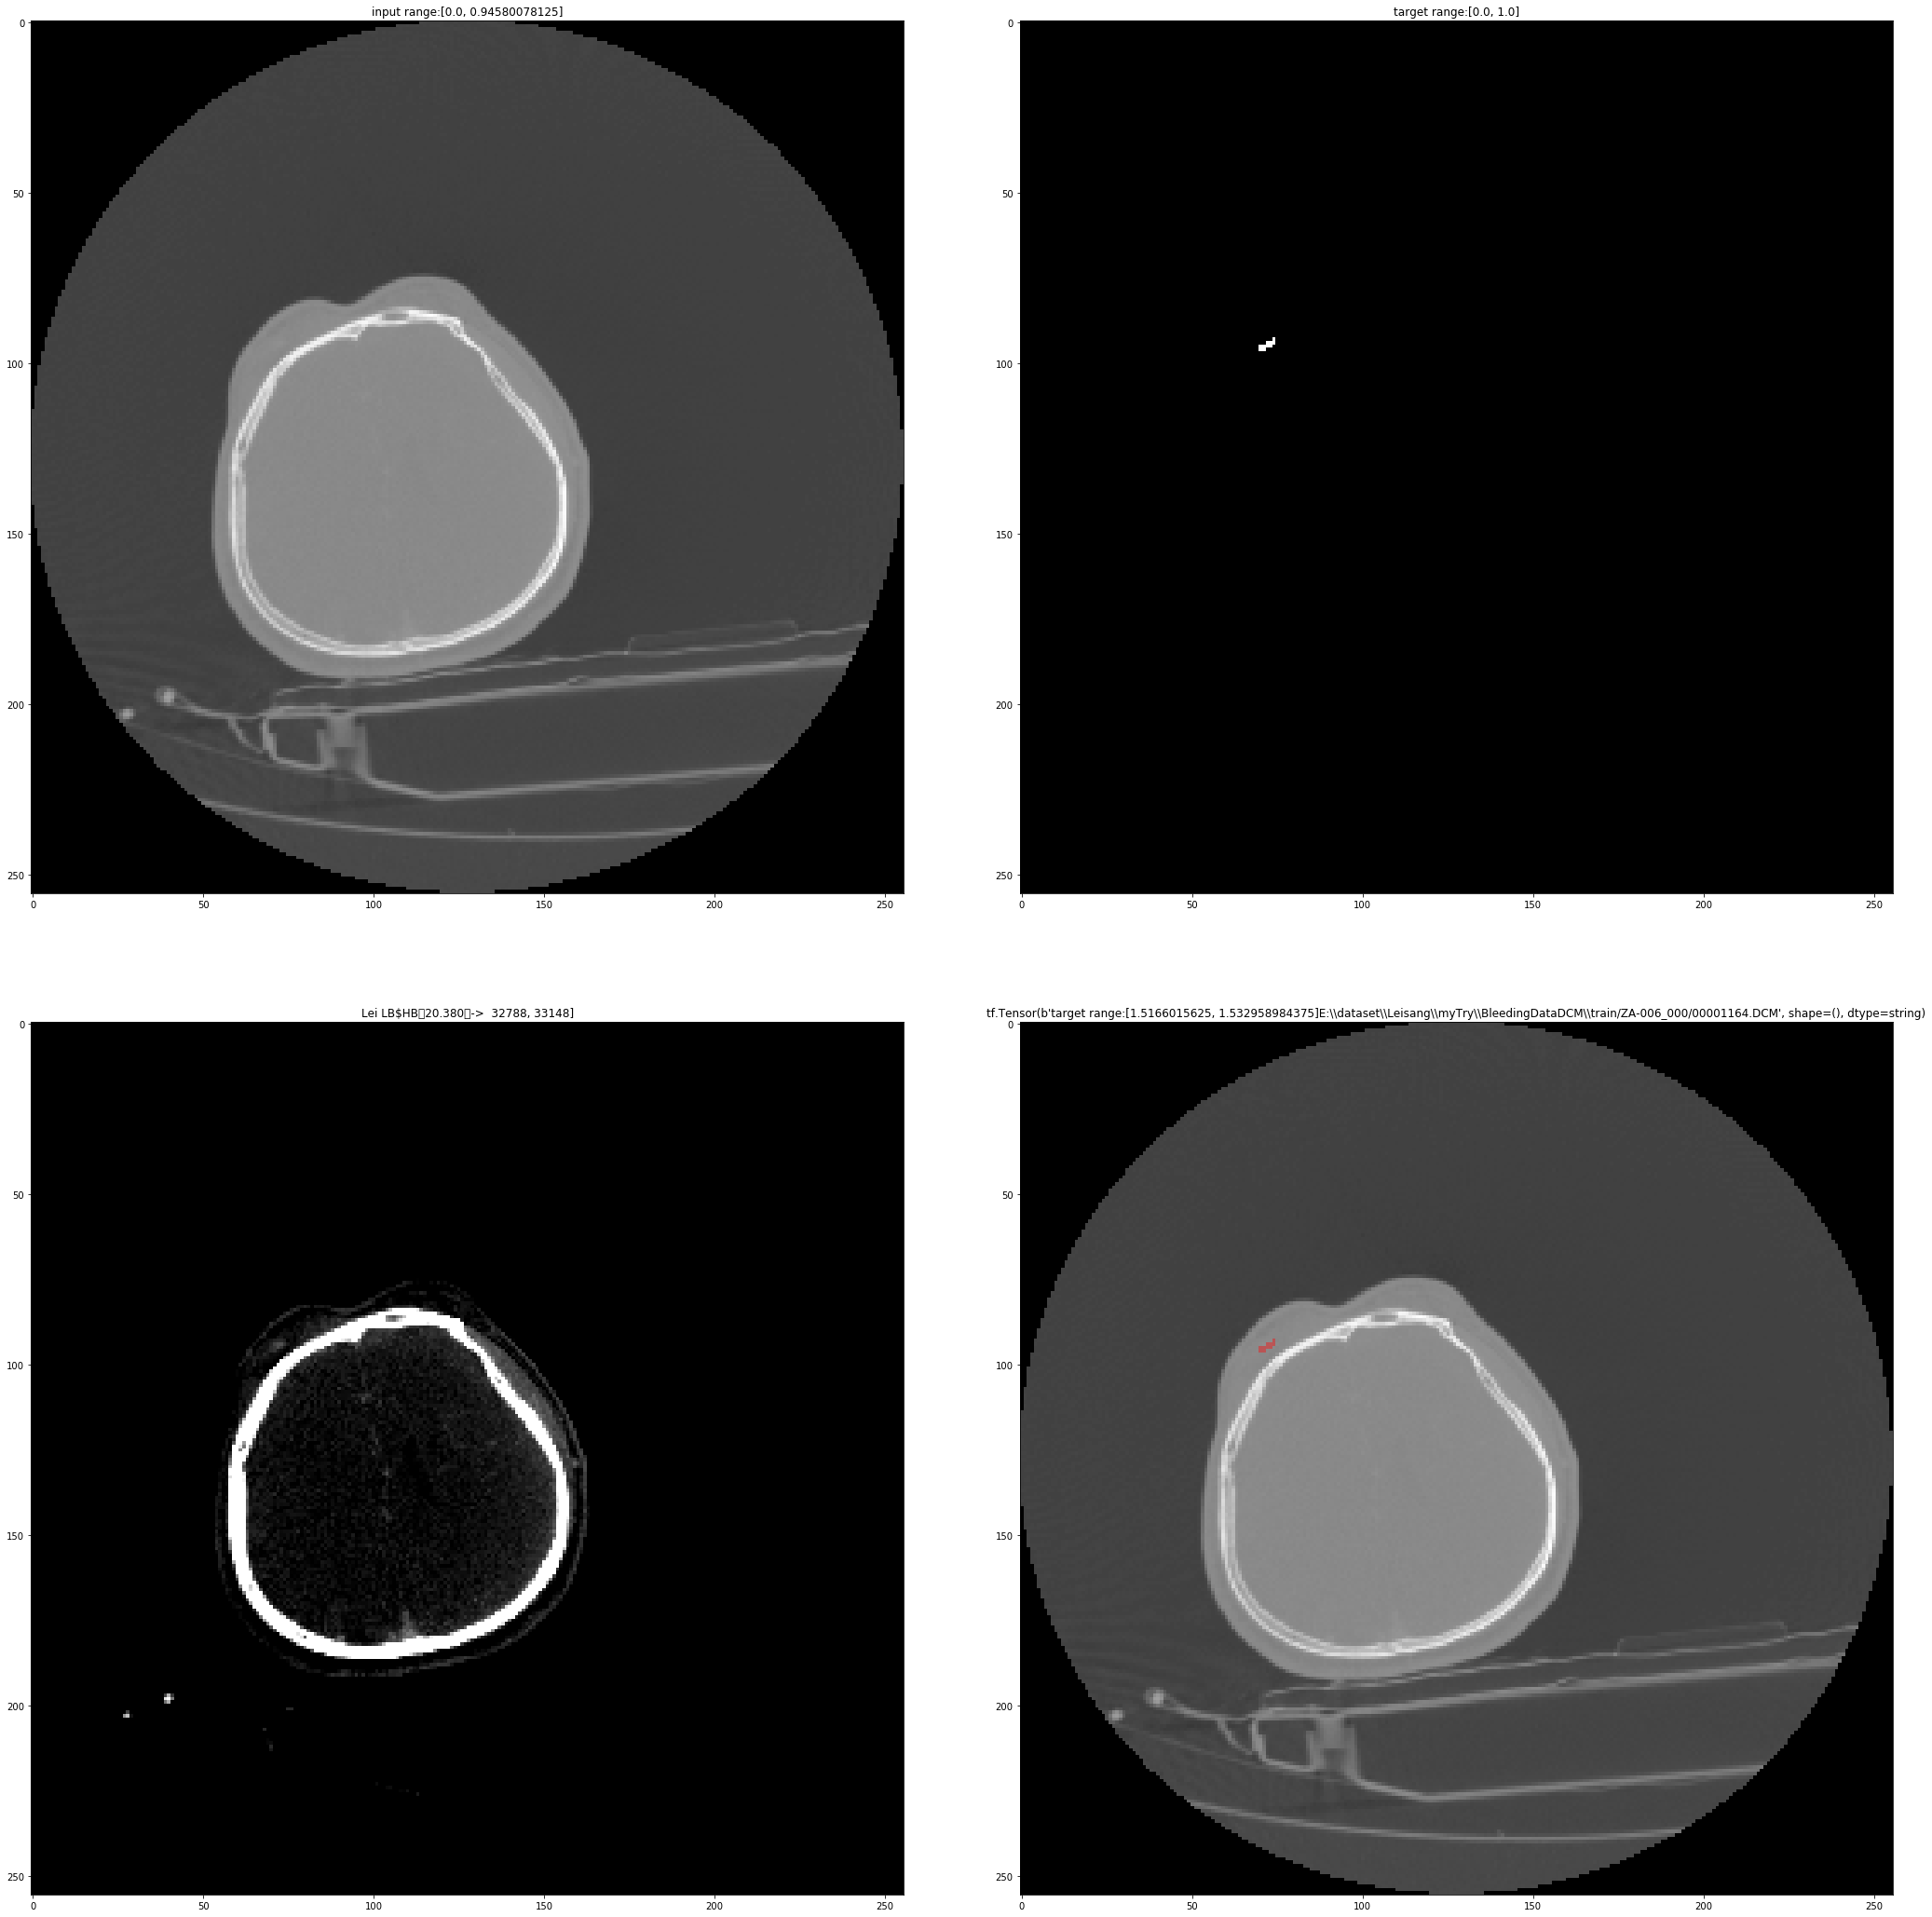

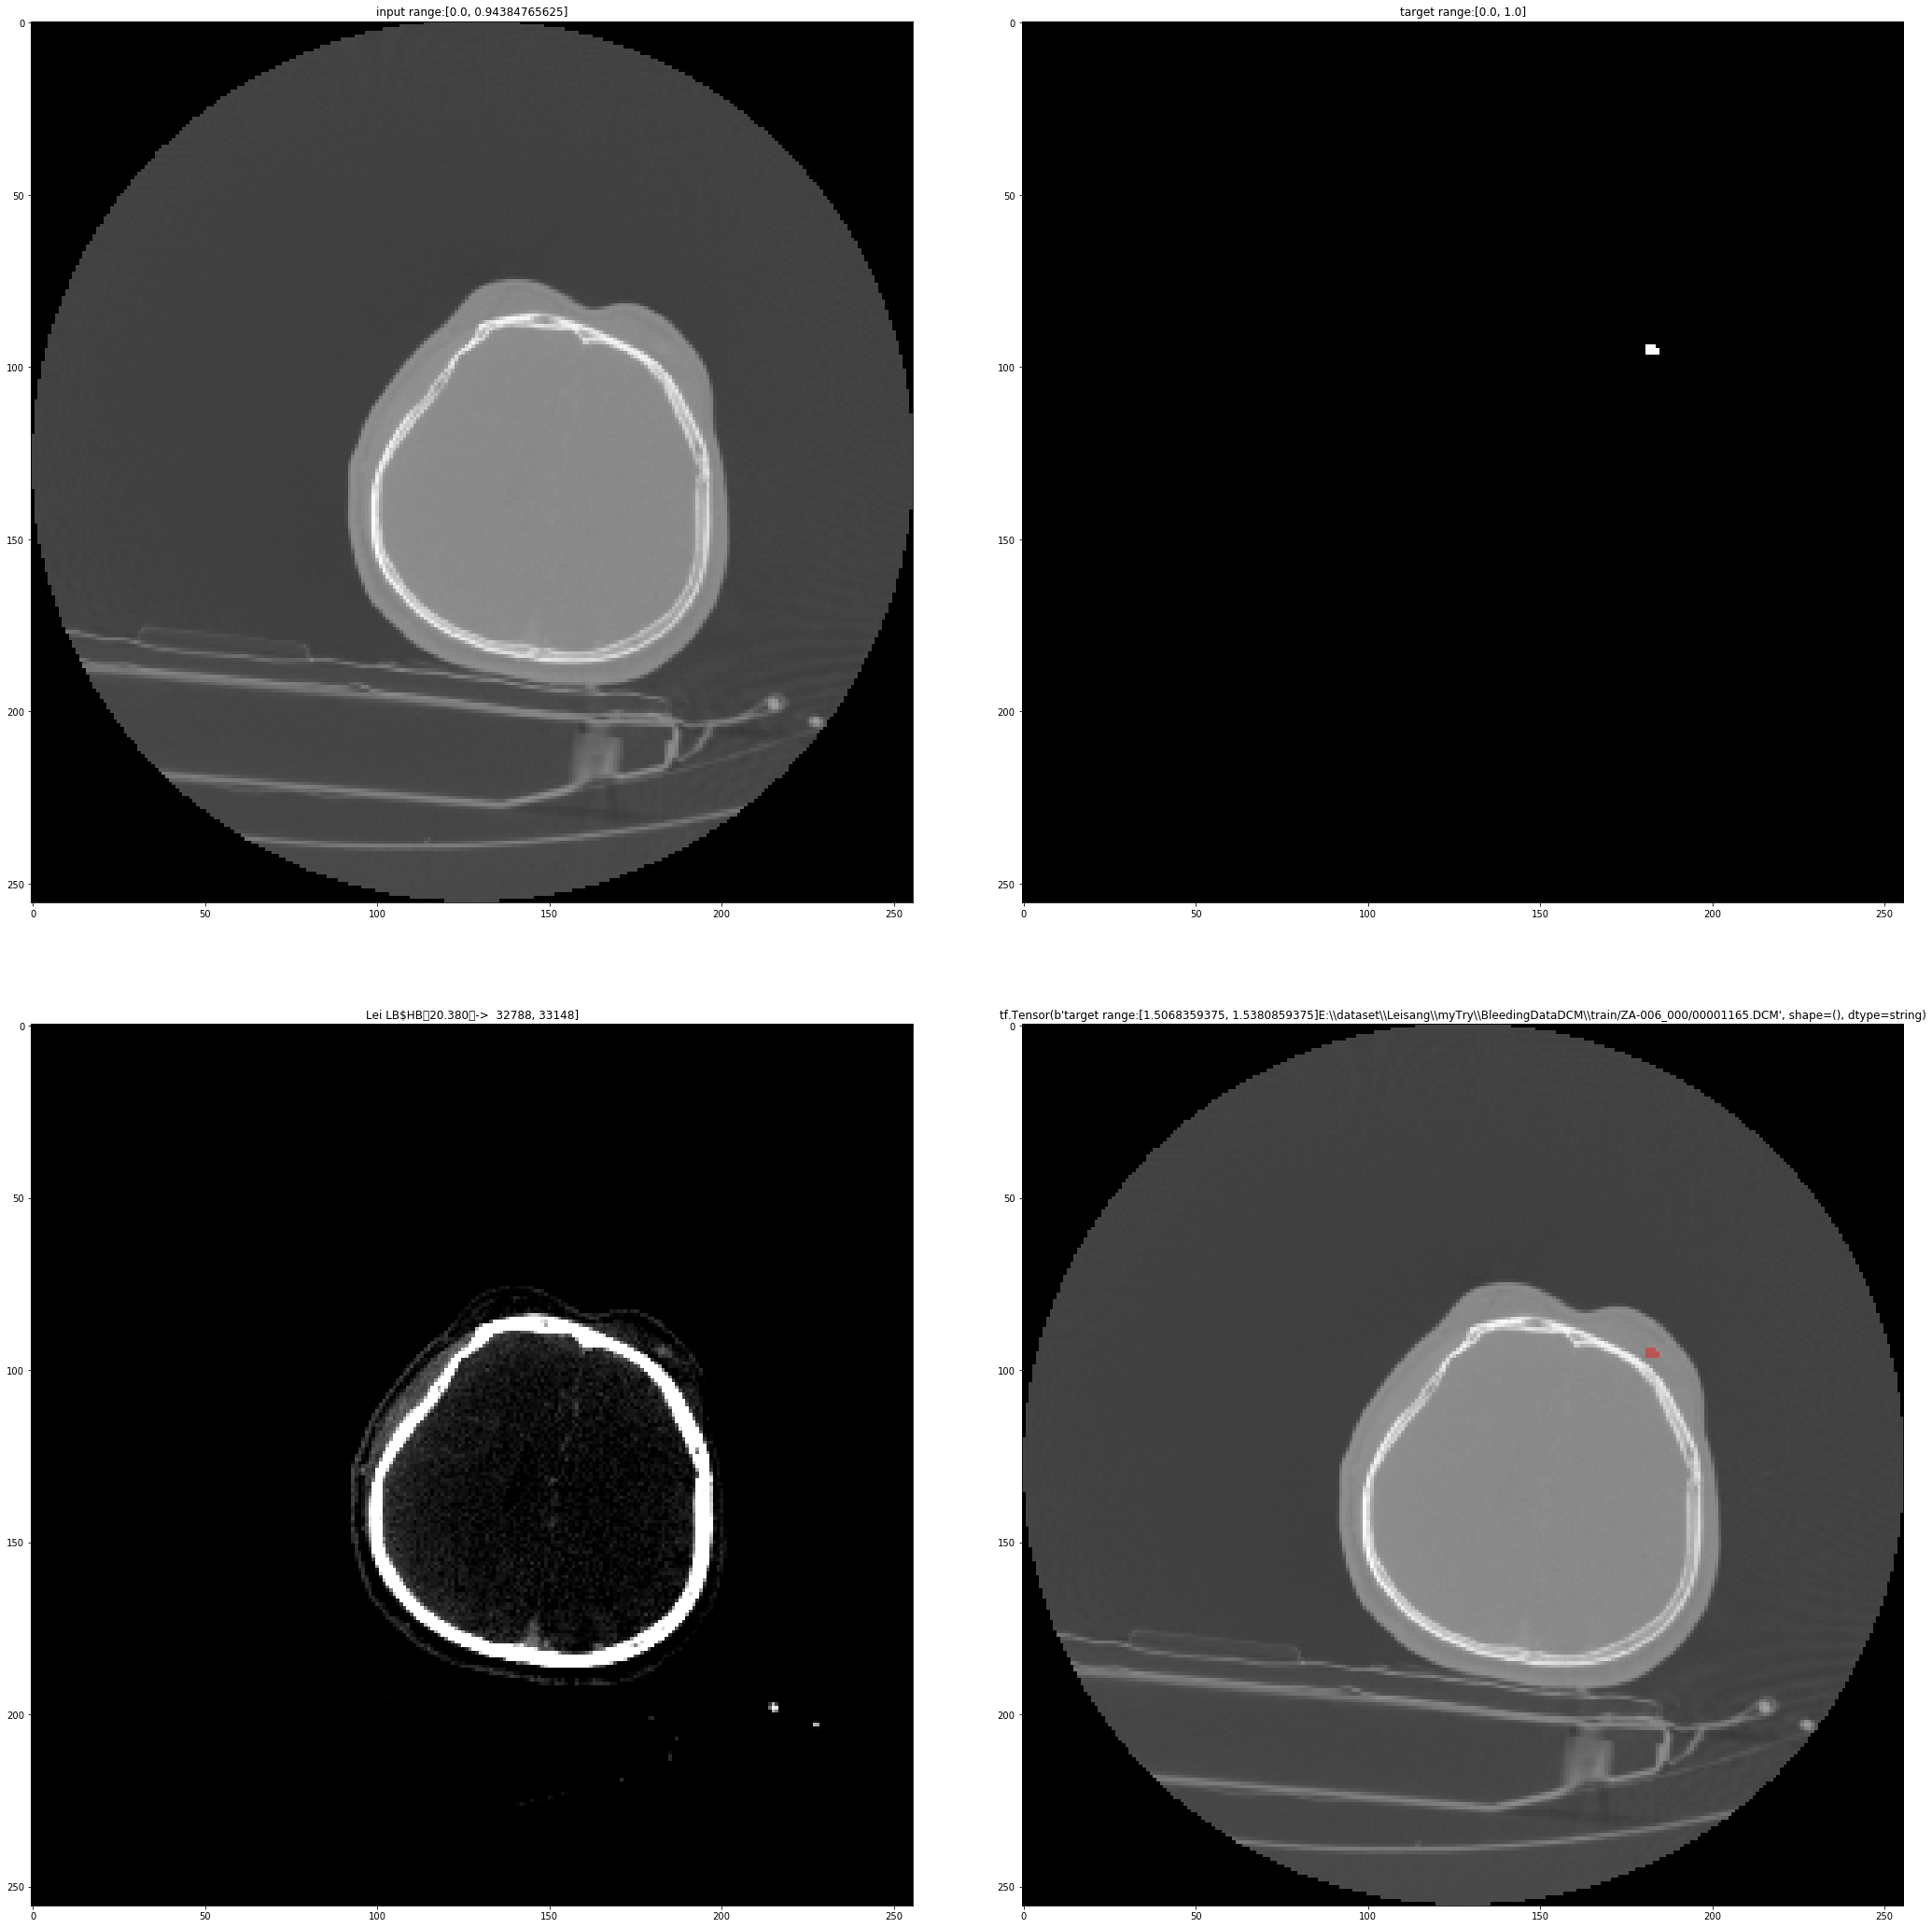

In [6]:
# # check the dataset
# def winwise(input,LB,HB):
#         # 20 ,380 for range (-32768, 32767)
#         # for tf input , (0, 65535)-? LB =  32788, 33148
#         input[input<LB] = LB # low boundary , if < LW , set to LW
#         input[input>HB] = HB # high boundary, if > Hw, Set to 255
#         return input


palette = copy(plt.cm.gray)
palette.set_over('r', 1.0)
for image_features in parsed_train_positive_dataset.take(2):
    dicom_path =  image_features[0]
    norm_input_w_image =  image_features[1]
    norm_input =  image_features[2]
    #     dicom_path = image_features[0].numpy()
    norm_target = image_features[3]
    cls_label = image_features[4]
    print("dicom_path:", dicom_path)
    print("input_image.shape", norm_input.shape)
    print("seg_label", norm_target.shape)
    print("cls_label", cls_label)
    # reshape label 
#     norm_target =  tf.reshape(norm_target, norm_input.shape)
    # # for lab ubuntu system
    # input, target, image_path= load('/media/ytx/Japan_Deep_Data/dataset/LeiSang/myTry/BleedingDataDCM/train/ZA-006_000/00000001.DCM')
    fig, axes = plt.subplots(2,2, figsize=(30,30))

    axes[0, 0].imshow(np.squeeze(norm_input.numpy()), cmap='gray')
    axes[0, 0].set_title('input range:[{}, {}]'.format((norm_input.numpy().min()), np.max(norm_input.numpy())))
    axes[0, 1].imshow(np.squeeze(norm_target.numpy()), cmap='gray')
    axes[0, 1].set_title('target range:[{}, {}]'.format(np.min(norm_target), np.max(norm_target)))
    
    axes[1, 0].imshow(np.squeeze(norm_input_w_image), cmap='gray')
    axes[1, 0].set_title('Lei LB$HB：20.380：->  32788, 33148]')
    
    mask =  np.squeeze(norm_target.numpy())
    masked_in = norm_target + norm_input
    print('masked_in range:[{}, {}]'.format((masked_in.numpy().min()), masked_in.numpy().max()))

    masked = np.ma.masked_where(norm_target==0, masked_in)  # this is only generated mask
    print('masked range:[{}, {}]'.format(masked.min(), masked.max())) 
    axes[1, 1].imshow(np.squeeze(norm_input), cmap='gray')
    axes[1, 1].imshow(np.squeeze(masked), palette, colors.Normalize(vmin=0, vmax=1), interpolation='none', alpha=0.4)
    axes[1, 1].set_title('target range:[{}, {}]'.format(np.min(masked), np.max(masked)) + dicom_path)
    fig.tight_layout()
    
    print(dicom_path)

## DEFINE LOAD FUNCTION IN INPUT PIPELINE

## INPUT PIPELINE

In [7]:
# balance the dataset
BUFFER_SIZE = 1024
BATCH_SIZE = 2
train_dataset = tf.data.experimental.sample_from_datasets([parsed_train_positive_dataset, parsed_train_negative_dataset], weights=[0.5, 0.5])

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(2)

test_dataset = parsed_val_positive_dataset.concatenate(parsed_val_negative_dataset)
# test_dataset = test_dataset.shuffle(BUFFER_SIZE)  # for the random check if not comment it
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(2)


# # test positive dataset
# test_positive_dataset =  parsed_val_positive_dataset
# test_positive_dataset = test_positive_dataset.batch(BATCH_SIZE).prefetch(2)
# # test negative dataset
# test_negative_dataset =  parsed_val_negative_dataset
# test_negative_dataset = test_negative_dataset.batch(BATCH_SIZE).prefetch(2)

# To use this dataset, you'll need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each positive example once:

In [8]:
resampled_steps_per_epoch = np.ceil(2.0*train_nb_pos/BATCH_SIZE)

n_positive_test_batches = np.ceil(val_nb_pos/BATCH_SIZE)

dicom_path: tf.Tensor(b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000435.DCM', shape=(), dtype=string)
input_image.shape (256, 256, 1)
seg_label (256, 256, 1)
cls_label tf.Tensor(1, shape=(), dtype=int64)
masked_in range:[0.0, 1.531982421875]
masked range:[1.51318359375, 1.531982421875]
tf.Tensor(b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000435.DCM', shape=(), dtype=string)


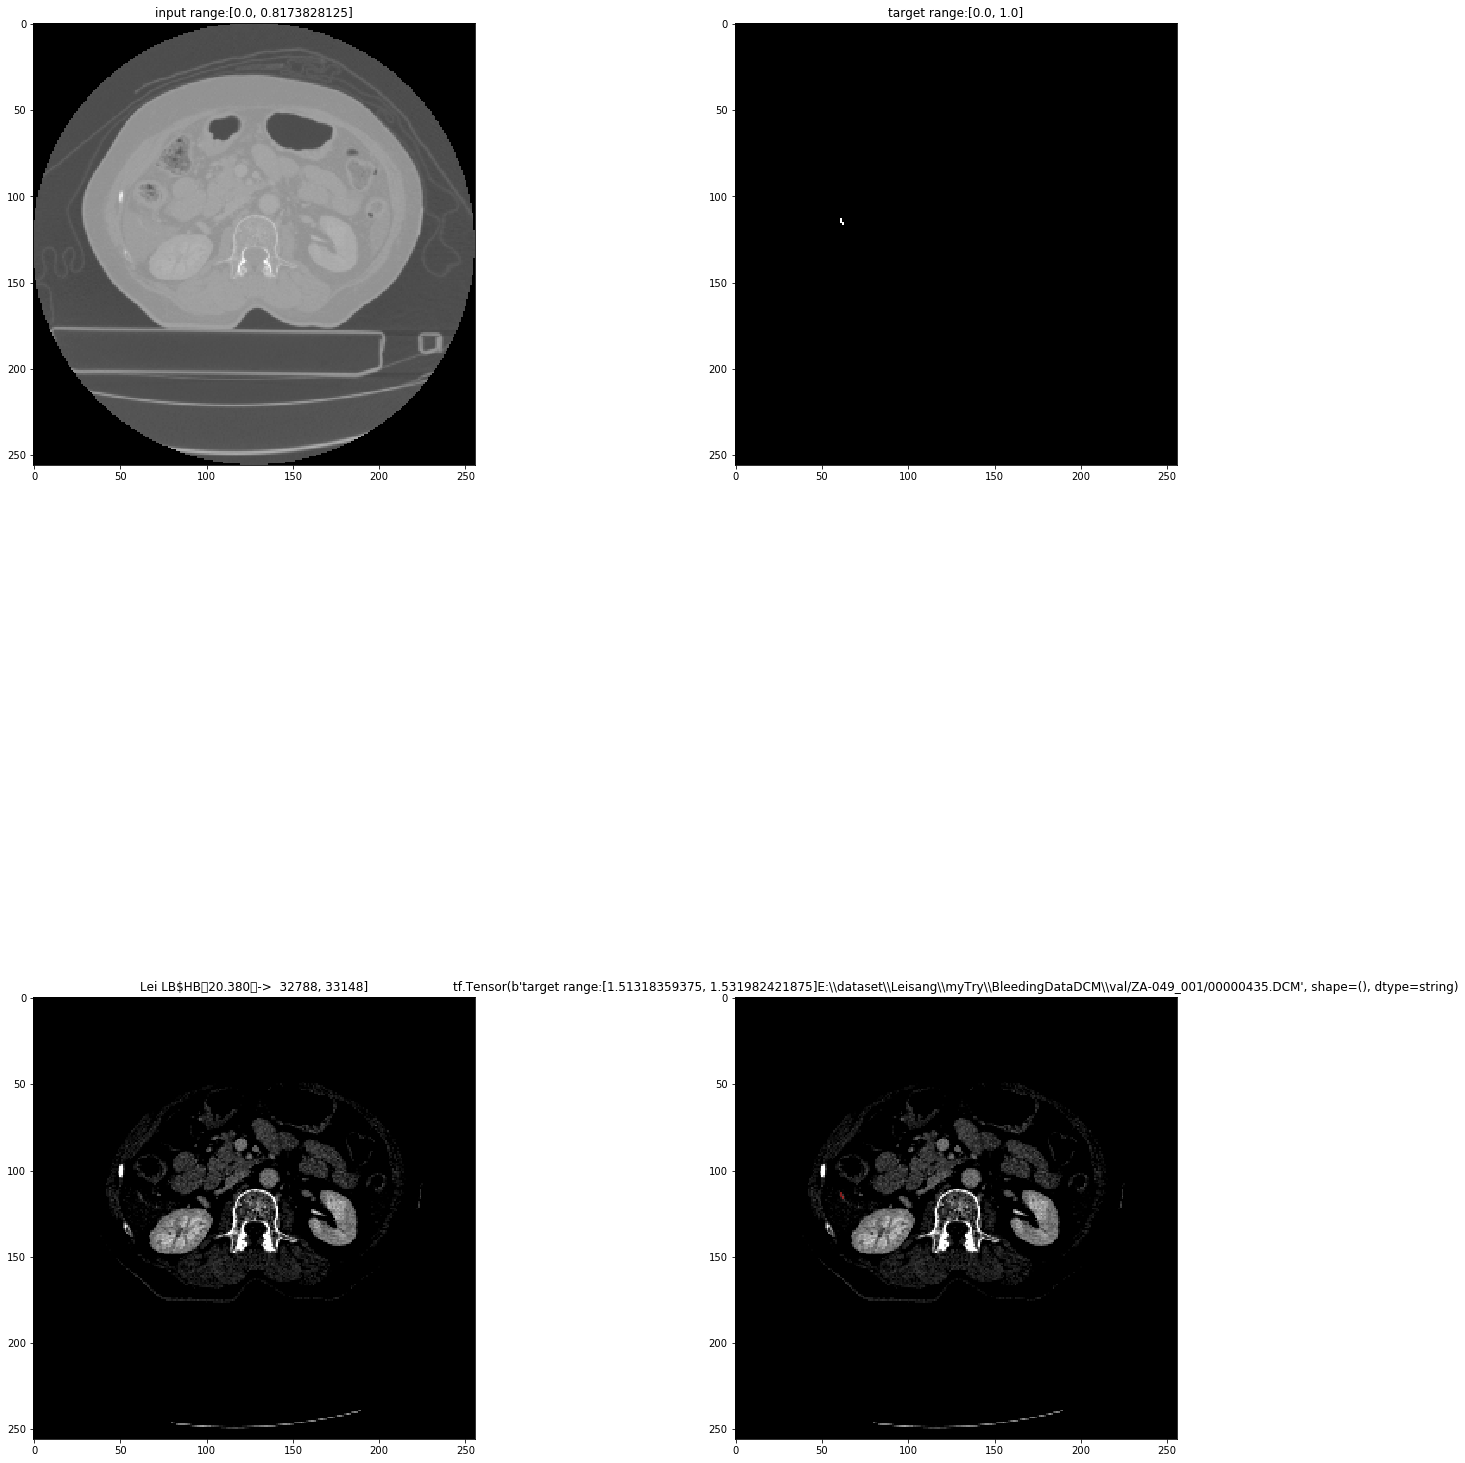

In [9]:
#  check the dataset
for image_features  in test_dataset.take(1):
    dicom_path =  image_features[0][0]
    norm_input_w_image =  image_features[1][0]
    norm_input =  image_features[2][0]
    #     dicom_path = image_features[0].numpy()
    norm_target = image_features[3][0]
    cls_label = image_features[4][0]
    print("dicom_path:", dicom_path)
    print("input_image.shape", norm_input.shape)
    print("seg_label", norm_target.shape)
    print("cls_label", cls_label)
    
    fig, axes = plt.subplots(2,2, figsize=(20,30))

    axes[0, 0].imshow(np.squeeze(norm_input.numpy()), cmap='gray')
    axes[0, 0].set_title('input range:[{}, {}]'.format((norm_input.numpy().min()), np.max(norm_input.numpy())))
    axes[0, 1].imshow(np.squeeze(norm_target.numpy()), cmap='gray')
    axes[0, 1].set_title('target range:[{}, {}]'.format(np.min(norm_target), np.max(norm_target)))
    
    axes[1, 0].imshow(np.squeeze(norm_input_w_image), cmap='gray')
    axes[1, 0].set_title('Lei LB$HB：20.380：->  32788, 33148]')
    
    mask =  np.squeeze(norm_target.numpy())
    masked_in = norm_target + norm_input
    print('masked_in range:[{}, {}]'.format((masked_in.numpy().min()), masked_in.numpy().max()))

    masked = np.ma.masked_where(norm_target==0, masked_in)  # this is only generated mask
    print('masked range:[{}, {}]'.format(masked.min(), masked.max())) 
    axes[1, 1].imshow(np.squeeze(norm_input_w_image), cmap='gray')
    axes[1, 1].imshow(np.squeeze(masked), palette, colors.Normalize(vmin=0, vmax=1), interpolation='none', alpha=0.4)
    axes[1, 1].set_title('target range:[{}, {}]'.format(np.min(masked), np.max(masked)) + dicom_path)
    fig.tight_layout()
    
    print(dicom_path)
    
    

## DESIGN MODEL

In [10]:
OUTPUT_CHANNELS = 1
latent_dim =50

In [11]:
# model input conponents
en_inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT,IMG_HEIGHT,1])
de_inputs = tf.keras.layers.Input(shape=[latent_dim])
# full model design and construct encoder, decoder , AE object
# entire model

# Define encoder part ---->
x = en_inputs
x = tf.keras.layers.Conv2D(
                filters=16, kernel_size=3, strides=(1, 1), activation='relu', padding="same")(x)
x = tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu', padding="same")(x)
x = tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu', padding="SAME")(x)
x = tf.keras.layers.Conv2D(
                filters=128, kernel_size=3, strides=(2, 2), activation='relu',padding="SAME")(x)
x = tf.keras.layers.Flatten()(x)
# No activation
latent_v = tf.keras.layers.Dense(latent_dim)(x)
encoder = tf.keras.Model(inputs=en_inputs, outputs=latent_v, name='encoder')


# Define decoder part ---->
x = tf.keras.layers.Dense(units=131072, activation=tf.nn.relu)(de_inputs)
x = tf.keras.layers.Reshape(target_shape=(32, 32, 128))(x)
x = tf.keras.layers.Conv2DTranspose(
      filters=64,
      kernel_size=3,
      strides=(2, 2),
      padding="SAME",
      activation='relu')(x)
x = tf.keras.layers.Conv2DTranspose(
      filters=32,
      kernel_size=3,
      strides=(2, 2),
      padding="SAME",
      activation='relu')(x)
x = tf.keras.layers.Conv2DTranspose(
      filters=16,
      kernel_size=3,
      strides=(2, 2),
      padding="SAME",
      activation='relu')(x)

decoded = tf.keras.layers.Conv2DTranspose(
      filters=1, kernel_size=3, strides=(1, 1), padding="SAME", use_bias=True)(x)
# output with sigmoid
decoded =  tf.sigmoid(decoded)
decoder = tf.keras.Model(inputs=de_inputs, outputs=decoded, name='decoder')


# Define AE model---->
outputs = decoder(latent_v)
autoencoder =  tf.keras.Model(inputs=en_inputs, outputs=outputs, name='AE')

# a sperately decoder is struggle leave for the moment

# # # create a placeholder for an encoded (32-dimensional) input
# encoded_input = tf.keras.layers.Input(shape=(latent_dim))
# # # retrieve the last layer of the autoencoder model
# decoder_layer = autoencoder.layers[-1]
# # # create the decoder model
# decoder = tf.keras.Model(encoded_input, decoder_layer)
             

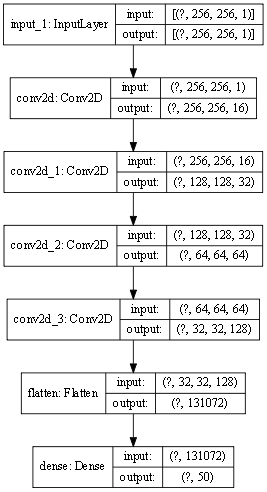

In [12]:
tf.keras.utils.plot_model(encoder, to_file=encoder_path, show_shapes=True, dpi=64)

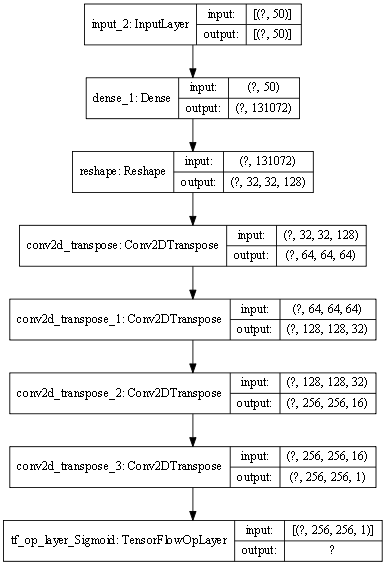

In [13]:
tf.keras.utils.plot_model(decoder, to_file=decoder_path, show_shapes=True, dpi=64)

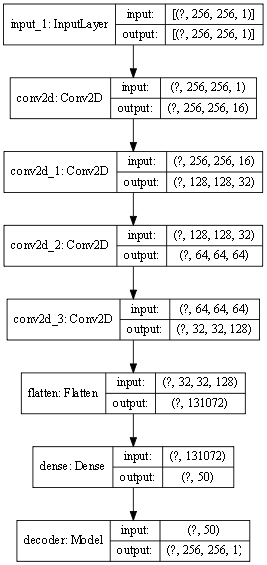

In [14]:
tf.keras.utils.plot_model(autoencoder, to_file=autoencoder_path, show_shapes=True, dpi=64)

## OPTIMIZER AND OBJECTIVE LOSSES


In [15]:

# BCE =  tf.keras.losses.BinaryCrossentropy() 
# Huber =  tf.keras.losses.Huber(delta=0.1)
# @tf.function()
# # define losses
# def compute_loss(decoded_x, x):
    
#     # cross_entropy,  use reduce mean not sum, otherwise loss will be very big
#     BCE_loss = BCE(y_true=x, y_pred=decoded_x) 
    
    
#     # L1 loss 
# #     L1_loss = tf.reduce_mean(tf.abs(x - decoded_x))
    
#     # Huber_loss
#     Huber_loss = Huber(y_true=x, y_pred=decoded_x)
#     total_loss = Huber_loss + BCE_loss
#     return total_loss, BCE_loss, Huber_loss
    
# # appliy graidients  this is acutaully trianing step
# # @tf.function()
# # def compute_apply_gradients(model, x, optimizer, epoch):
# #     decoded_x =  model(x)
# #     with tf.GradientTape() as tape:
# #         total_loss, CE_loss, L1_loss = compute_loss(decoded_x, x)
# #     gradients = tape.gradient(total_loss, model.trainable_variables)
# #     optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
# #     with summary_writer.as_default():
# #         # write scalars to the tensorboard after each train step
# #         tf.summary.scalar('total_loss', total_loss, step=epoch)
# #         tf.summary.scalar('CE_loss', CE_loss, step=epoch)
# #         tf.summary.scalar('L1_loss', L1_loss, step=epoch) 
# @tf.function()
# def train_step(model, input, target, epoch):
#     print("in trianing step")
#     with tf.GradientTape() as tape:  # very interesting
#         decoded_img = model(input, training=True)
#         total_loss, BCE_loss, Huber_loss = compute_loss(decoded_img, target)
#     gradients = tape.gradient(total_loss, model.trainable_variables)
#     optimizer.apply_gradients(zip(gradients, model.trainable_variables))
#     return total_loss, BCE_loss, Huber_loss

# @tf.function()
# def test_step(model, input, target, epoch):
#     with tf.GradientTape() as tape:  # very interesting
#         decoded_img = model(input, training=True)
#         total_loss, BCE_loss, Huber_loss = compute_loss(decoded_img, target)
#     return total_loss, BCE_loss, Huber_loss
# #     train_avg_loss(train_loss)
# #     train_avg_metric(metric)     

In [16]:
# # check the AE OUTPUT
# print("inp.shape:", cliped_norm_input.shape)
# print("inp[tf.newaxis,...]:", cliped_norm_input[tf.newaxis,...].shape)
# AE_output = autoencoder(resized_input[tf.newaxis,...], training=False)  # inp is the image sample from cell code 6 ; 
# print(AE_output.shape)
# plt.imshow(np.squeeze(AE_output[0,...]), cmap="gray")

## Training PREPARING

In [23]:
## get current working directory
cwd = os.getcwd()
print("current working directory:", cwd)
train_full_AE_saves =  os.path.join(cwd, train_save_figure_path)
test_full_AE_saves =  os.path.join(cwd, test_save_figure_path)
print("train_full_AE_saves:", train_full_AE_saves)
print("test_full_AE_saves:", test_full_AE_saves)


if not os.path.exists(train_full_AE_saves):
    os.makedirs(train_full_AE_saves)

if not os.path.exists(test_full_AE_saves):
    os.makedirs(test_full_AE_saves)
    
    
train_predictions_save_path =os.path.join(train_full_AE_saves, "Predictions")
test_predictions_save_path =os.path.join(test_full_AE_saves, "Predictions")
test_confusion_matrix =  os.path.join(test_full_AE_saves, "Confusion_Matrix")


test_EpochValidation_save_path =os.path.join(test_full_AE_saves, "EpochValidation")
test_EpochValidation_save_path_pred =os.path.join(test_EpochValidation_save_path, "PredictionsOnly")
if not os.path.exists(train_predictions_save_path):
    os.makedirs(train_predictions_save_path)
if not os.path.exists(test_predictions_save_path):
    os.makedirs(test_predictions_save_path)
if not os.path.exists(test_EpochValidation_save_path):
    os.makedirs(test_EpochValidation_save_path)
if not os.path.exists(test_EpochValidation_save_path_pred):
    os.makedirs(test_EpochValidation_save_path_pred)   
if not os.path.exists(test_confusion_matrix):
    os.makedirs(test_confusion_matrix)       
    
    
def en_de_generate_images(en, de, norm_input, norm_input_w_image, norm_target, path, save=True, Train_or_not=True):
#     prediction = model(test_input, training=True)
    
    laten_v = en(norm_input, training=False)
    prediciton = de(laten_v)
    print("prediciton shape:", prediciton.shape)
    
    pred =  prediciton[0]
    
    norm_input =norm_input[0]
    norm_input_w_image =norm_input_w_image[0]
    norm_target =norm_target[0]
    path = path[0]
#     display_list = [np.squeeze(test_input[0]), np.squeeze(tar[0]), np.squeeze(prediction[0])]
#     title = ['Input range:[{},{}]'.format(test_input[0].numpy().min(), test_input[0].numpy().max()), 
#            'GT range:[{},{}]'.format(tar[0].numpy().min(), tar[0].numpy().max()), 'en-to-de Pred. out {}'.format(prediction.shape)]
    
    fig, axes = plt.subplots(3,2, figsize =(20,30))
    axes[0, 0].imshow(np.squeeze(norm_input.numpy()), cmap='gray')
    axes[0, 0].set_title('input range:[{}, {}]'.format((norm_input.numpy().min()), np.max(norm_input.numpy())))
    axes[0, 1].imshow(np.squeeze(norm_target.numpy()), cmap='gray')
    axes[0, 1].set_title('target range:[{}, {}]'.format(np.min(norm_target), np.max(norm_target)))
    
    axes[1, 0].imshow(np.squeeze(norm_input_w_image), cmap='gray')
    axes[1, 0].set_title('Lei LB$HB 20,380->  32788, 33148]')
    
    mask =  np.squeeze(norm_target.numpy())
    masked_in = norm_target + norm_input
    print('masked_in range:[{}, {}]'.format((masked_in.numpy().min()), masked_in.numpy().max()))

    masked = np.ma.masked_where(norm_target==0, masked_in)  # this is only generated mask
    print('masked range:[{}, {}]'.format(masked.min(), masked.max())) 
    axes[1, 1].imshow(np.squeeze(norm_input_w_image), cmap='gray')
    
    palette1 = copy(plt.cm.gray)
    palette1.set_over('r', 1.0)
    axes[1, 1].imshow(np.squeeze(masked), palette1, colors.Normalize(vmin=0, vmax=1), interpolation='none', alpha=0.4)
    axes[1, 1].set_title('target range:[{}, {}]: \n {}'.format(np.min(masked), np.max(masked), path))
    
    
    
    mask2 =  np.squeeze(pred.numpy())
    axes[2, 0].imshow(mask2, cmap='gray')
    axes[2, 0].set_title('Se Pred range:[{}, {}]; '.format(np.min(mask2), np.max(mask2)))
    
    
    # binarize prediction
    mask2[mask2>0.5] = 1
    mask2[mask2<=0.5] = 0
    
    masked_in2 = mask2 + np.squeeze(norm_input)
    print("norm_input_w_image.shape:",norm_input_w_image.shape)
    print("mask2 shape:", mask2.shape)
    print("masked_in2 shape:", masked_in2.shape)
    
    print('masked_in range:[{}, {}]'.format((masked_in2.min()), masked_in2.max()))
    
    masked2 = np.ma.masked_where(mask2==0, masked_in2)  # this is only generated mask
    print('masked range:[{}, {}]'.format(masked2.min(), masked2.max())) 
    axes[2, 1].imshow(np.squeeze(norm_input_w_image), cmap='gray')
    palette2 = copy(plt.cm.gray)
    palette2.set_over('y', 1.0)
    axes[2, 1].imshow(np.squeeze(masked2), palette2, colors.Normalize(vmin=0, vmax=1), interpolation='none', alpha=0.4)
    axes[2, 1].set_title('Seg Bi Pred range:[{}, {}]'.format(np.min(mask2), np.max(mask2)))
    fig.tight_layout() 
    fig.subplots_adjust(wspace=0.0)
#     axes.axis('off')
    
    
#     fig.tight_layout()
     
    
    
    plt.figure(figsize=(8,8))
    plt.title('Compare Pred(Yellow) & Label(red) ' )
    plt.imshow(np.squeeze(norm_input_w_image), cmap='gray')
    plt.imshow(np.squeeze(masked), palette1, colors.Normalize(vmin=0, vmax=1), interpolation='none', alpha=0.4)
    palette.set_over('y', 1.0)
    plt.imshow(np.squeeze(masked2), palette2, colors.Normalize(vmin=0, vmax=1), interpolation='none', alpha=0.4)
    plt.axis('off')

    plt.show()
    
    
    
def new_generate_images(model, norm_input, norm_input_w_image, norm_target, cls_target, path, batch_idx, epoch, save=True, Train_or_not=True, Epoch_val =False):
#     prediction = model(test_input, training=True)
    
    seg_out, class_sigmoid_output = model(norm_input, training=False)
    print("seg_out shape:", seg_out.shape)
    
    cls_pred =  np.argmax(class_sigmoid_output[0])
    seg_pred =  seg_out[0]
    
    norm_input =norm_input[0]
    norm_input_w_image =norm_input_w_image[0]
    norm_target =norm_target[0]
    cls_target = cls_target[0]
    path = path[0]
#     display_list = [np.squeeze(test_input[0]), np.squeeze(tar[0]), np.squeeze(prediction[0])]
#     title = ['Input range:[{},{}]'.format(test_input[0].numpy().min(), test_input[0].numpy().max()), 
#            'GT range:[{},{}]'.format(tar[0].numpy().min(), tar[0].numpy().max()), 'en-to-de Pred. out {}'.format(prediction.shape)]
    
    fig, axes = plt.subplots(3,2, figsize =(20,30))
    axes[0, 0].imshow(np.squeeze(norm_input.numpy()), cmap='gray')
    axes[0, 0].set_title('input range:[{}, {}]'.format((norm_input.numpy().min()), np.max(norm_input.numpy())))
    axes[0, 1].imshow(np.squeeze(norm_target.numpy()), cmap='gray')
    axes[0, 1].set_title('target range:[{}, {}]'.format(np.min(norm_target), np.max(norm_target)))
    
    axes[1, 0].imshow(np.squeeze(norm_input_w_image), cmap='gray')
    axes[1, 0].set_title('Lei LB$HB 20,380->  32788, 33148]')
    
    mask =  np.squeeze(norm_target.numpy())
    masked_in = norm_target + norm_input
    print('masked_in range:[{}, {}]'.format((masked_in.numpy().min()), masked_in.numpy().max()))

    masked = np.ma.masked_where(norm_target==0, masked_in)  # this is only generated mask
    print('masked range:[{}, {}]'.format(masked.min(), masked.max())) 
    axes[1, 1].imshow(np.squeeze(norm_input_w_image), cmap='gray')
    
    palette1 = copy(plt.cm.gray)
    palette1.set_over('r', 1.0)
    axes[1, 1].imshow(np.squeeze(masked), palette1, colors.Normalize(vmin=0, vmax=1), interpolation='none', alpha=0.4)
    axes[1, 1].set_title('target range:[{}, {}]: \n {}'.format(np.min(masked), np.max(masked), path))
    
    
    
    mask2 =  np.squeeze(seg_pred.numpy())
    axes[2, 0].imshow(mask2, cmap='gray')
    axes[2, 0].set_title('Seg Pred range:[{}, {}]; Cls Pred:{} Cls tar {}:'.format(np.min(mask2), np.max(mask2), cls_pred, cls_target.numpy() ))
    
    
    # binarize prediction
    mask2[mask2>0.5] = 1
    mask2[mask2<=0.5] = 0
    
    masked_in2 = mask2 + np.squeeze(norm_input)
    print("norm_input_w_image.shape:",norm_input_w_image.shape)
    print("mask2 shape:", mask2.shape)
    print("masked_in2 shape:", masked_in2.shape)
    
    print('masked_in range:[{}, {}]'.format((masked_in2.min()), masked_in2.max()))
    
    masked2 = np.ma.masked_where(mask2==0, masked_in2)  # this is only generated mask
    print('masked range:[{}, {}]'.format(masked2.min(), masked2.max())) 
    axes[2, 1].imshow(np.squeeze(norm_input_w_image), cmap='gray')
    palette2 = copy(plt.cm.gray)
    palette2.set_over('y', 1.0)
    axes[2, 1].imshow(np.squeeze(masked2), palette2, colors.Normalize(vmin=0, vmax=1), interpolation='none', alpha=0.4)
    axes[2, 1].set_title('Seg Bi Pred range:[{}, {}]; Cls Pred:{} Cls tar {}'.format(np.min(mask2), np.max(mask2), cls_pred,  cls_target.numpy()))
    fig.tight_layout() 
    fig.subplots_adjust(wspace=0.0)
#     axes.axis('off')
    
    
#     fig.tight_layout()
    
    if save==True :
        if Train_or_not:
            fig.savefig(train_save_figure_path + "/Train_image_at_epoch_{:04d}_batch_{}.png".format(epoch,batch_idx))
        else:
            if Epoch_val:
                fig.savefig(test_EpochValidation_save_path + "/Test_image_at_epoch_{:04d}_batch_{}_idx.png".format(epoch,batch_idx))
            else:
                fig.savefig(test_save_figure_path + "/Test_image_at_epoch_{:04d}_batch_{}.png".format(epoch,batch_idx))
     
    
    
    plt.figure(figsize=(12,12))
    
    plt.title('Compare Pred(Yellow) & Label(red) cls pred {}, cls tar {}\n Path:{}'.format(cls_pred,  cls_target.numpy(), path) )
    plt.imshow(np.squeeze(norm_input_w_image), cmap='gray')
    plt.imshow(np.squeeze(masked), palette1, colors.Normalize(vmin=0, vmax=1), interpolation='none', alpha=0.4)
    palette.set_over('y', 1.0)
    plt.imshow(np.squeeze(masked2), palette2, colors.Normalize(vmin=0, vmax=1), interpolation='none', alpha=0.4)
    plt.axis('off')
    if save ==True:
        if Train_or_not:
            plt.savefig(train_save_figure_path + "/Predictions/Train_pred_only_at_epoch_{:04d}_batch_{}.png".format(epoch,batch_idx))
        else:
            if Epoch_val:
                plt.savefig(test_EpochValidation_save_path_pred + "/Test_pred_only_at_epoch_{:04d}_batch_{}.png".format(epoch,batch_idx))
            else:
                plt.savefig(test_save_figure_path + "/Predictions/Test_pred_only_at_epoch_{:04d}_batch_{}.png".format(epoch,batch_idx))
    
    
    plt.show()

current working directory: E:\Projects\TF2\Dicom
train_full_AE_saves: E:\Projects\TF2\Dicom\5100LoadModelSegCls256_DropDisplayConfuRandFlipScrach/AE_saves/train
test_full_AE_saves: E:\Projects\TF2\Dicom\5100LoadModelSegCls256_DropDisplayConfuRandFlipScrach/AE_saves/test


## TRAINING

In [24]:
import datetime

epochs = 100
# define opitmizer 
optimizer =  tf.keras.optimizers.Adam(1e-4)






# define check points


# pre_saved_ckpt_path = os.path.join(checkpoint_dir, "ckpt")
# change to pre-saved model path: 
# 8 
# pre_saved_ckpt_path = "E:\\Projects\\logs\dicoms\\fixedArranged\\fixed\\8Bleed_AE_Huber_BCE_Sigmoid_NormNarrow_ShuffleTr_RandWinTrTe_SaveBest\\training_checkpoints\\ckpt"
# # for ubuntu
# pre_saved_ckpt_path = "/media/ytx/Japan_Deep_Data/DicomProject2020/logs/NewFramework/fixed/8Bleed_AE_Huber_BCE_Sigmoid_NormNarrow_ShuffleTr_RandWinTrTe_SaveBest/training_checkpoints/ckpt"
# # the path for the new training
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# if not os.path.exists(pre_saved_ckpt_path):
#     print("please check the pre-trained saved model path")
# #  contents of states to be saved as attributes on the checkpoint object
# checkpoint_ob = tf.train.Checkpoint(step= tf.Variable(1),
#                                     epoch=  tf.Variable(1),
#                                     optimizer=optimizer,
#                                  encoder=encoder,
#                                  decoder =  decoder,
#                                  autoencoder = autoencoder
#                                  )
# define restore checkpoint manager
# manager =  tf.train.CheckpointManager(checkpoint_ob, pre_saved_ckpt_path, max_to_keep=1)

# # define checkpoint manager for new training
# manager =  tf.train.CheckpointManager(checkpoint_ob, checkpoint_prefix, max_to_keep=1)

datetime_rec =  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

train_summary_writer = tf.summary.create_file_writer(
  log_dir + "train")
val_summary_writer = tf.summary.create_file_writer(
  log_dir + "val")

In [25]:
# start tensorboard
# !kill 5032
%load_ext tensorboard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 21720), started 0:02:30 ago. (Use '!kill 21720' to kill it.)

In [26]:
# # load pre-trained model
# checkpoint_ob.restore(restore_manager.latest_checkpoint)

# step =  checkpoint_ob.step
# epoch =  checkpoint_ob.epoch
# print(int(step))
# print(int(epoch))

# AE=  checkpoint_ob.autoencoder
# en = checkpoint_ob.encoder
# de =  checkpoint_ob.decoder
# print(AE)


AE=  autoencoder
en = encoder
de =  decoder

## use the pre-saved encoder as the base model and design the new model
base_model  = en
print(base_model.trainable)

dicom_path: tf.Tensor(
[b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000435.DCM'
 b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000436.DCM'], shape=(2,), dtype=string)
input_image.shape (2, 256, 256, 1)
seg_label (2, 256, 256, 1)
cls_label tf.Tensor([1 1], shape=(2,), dtype=int64)
prediciton shape: (2, 256, 256, 1)
masked_in range:[0.0, 1.531982421875]
masked range:[1.51318359375, 1.531982421875]
norm_input_w_image.shape: (256, 256, 1)
mask2 shape: (256, 256)
masked_in2 shape: (256, 256)
masked_in range:[0.0, 1.814208984375]
masked range:[1.0, 1.814208984375]


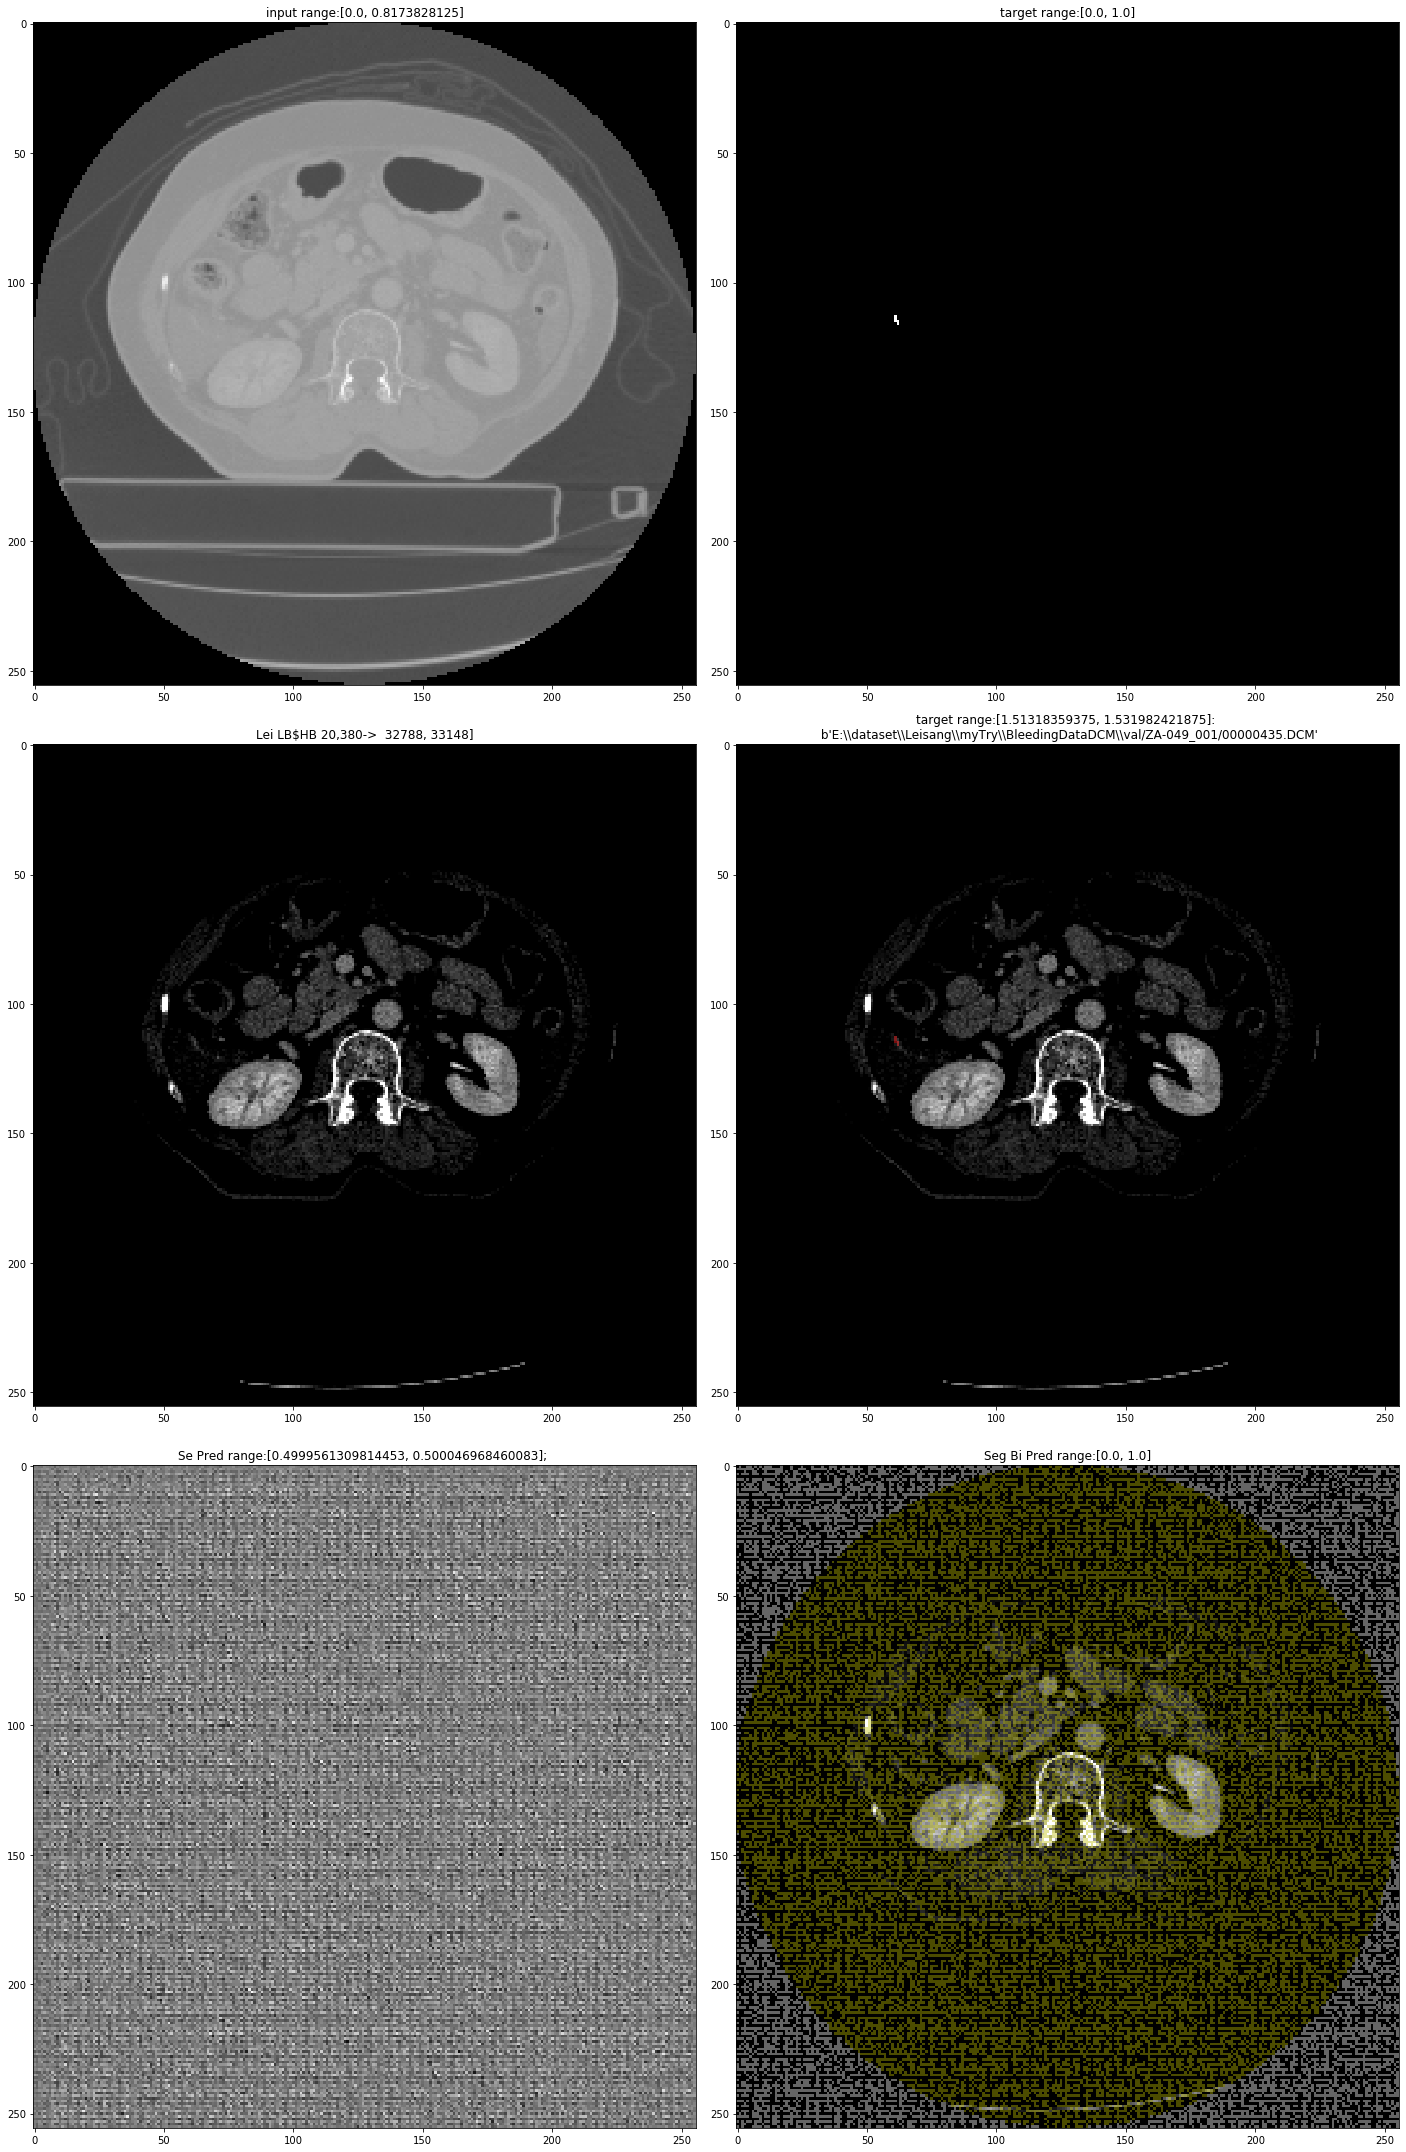

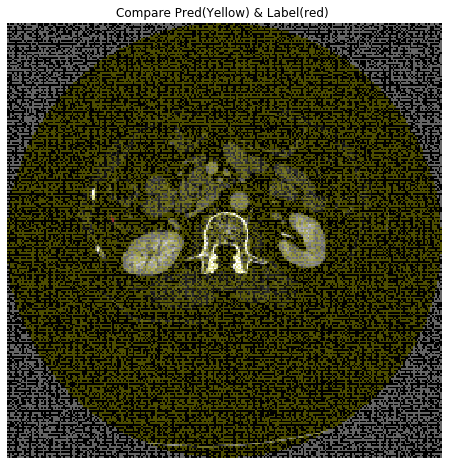

dicom_path: tf.Tensor(
[b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000437.DCM'
 b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000438.DCM'], shape=(2,), dtype=string)
input_image.shape (2, 256, 256, 1)
seg_label (2, 256, 256, 1)
cls_label tf.Tensor([1 1], shape=(2,), dtype=int64)
prediciton shape: (2, 256, 256, 1)
masked_in range:[0.0, 1.5302734375]
masked range:[1.511962890625, 1.5302734375]
norm_input_w_image.shape: (256, 256, 1)
mask2 shape: (256, 256)
masked_in2 shape: (256, 256)
masked_in range:[0.0, 1.77294921875]
masked range:[1.0, 1.77294921875]


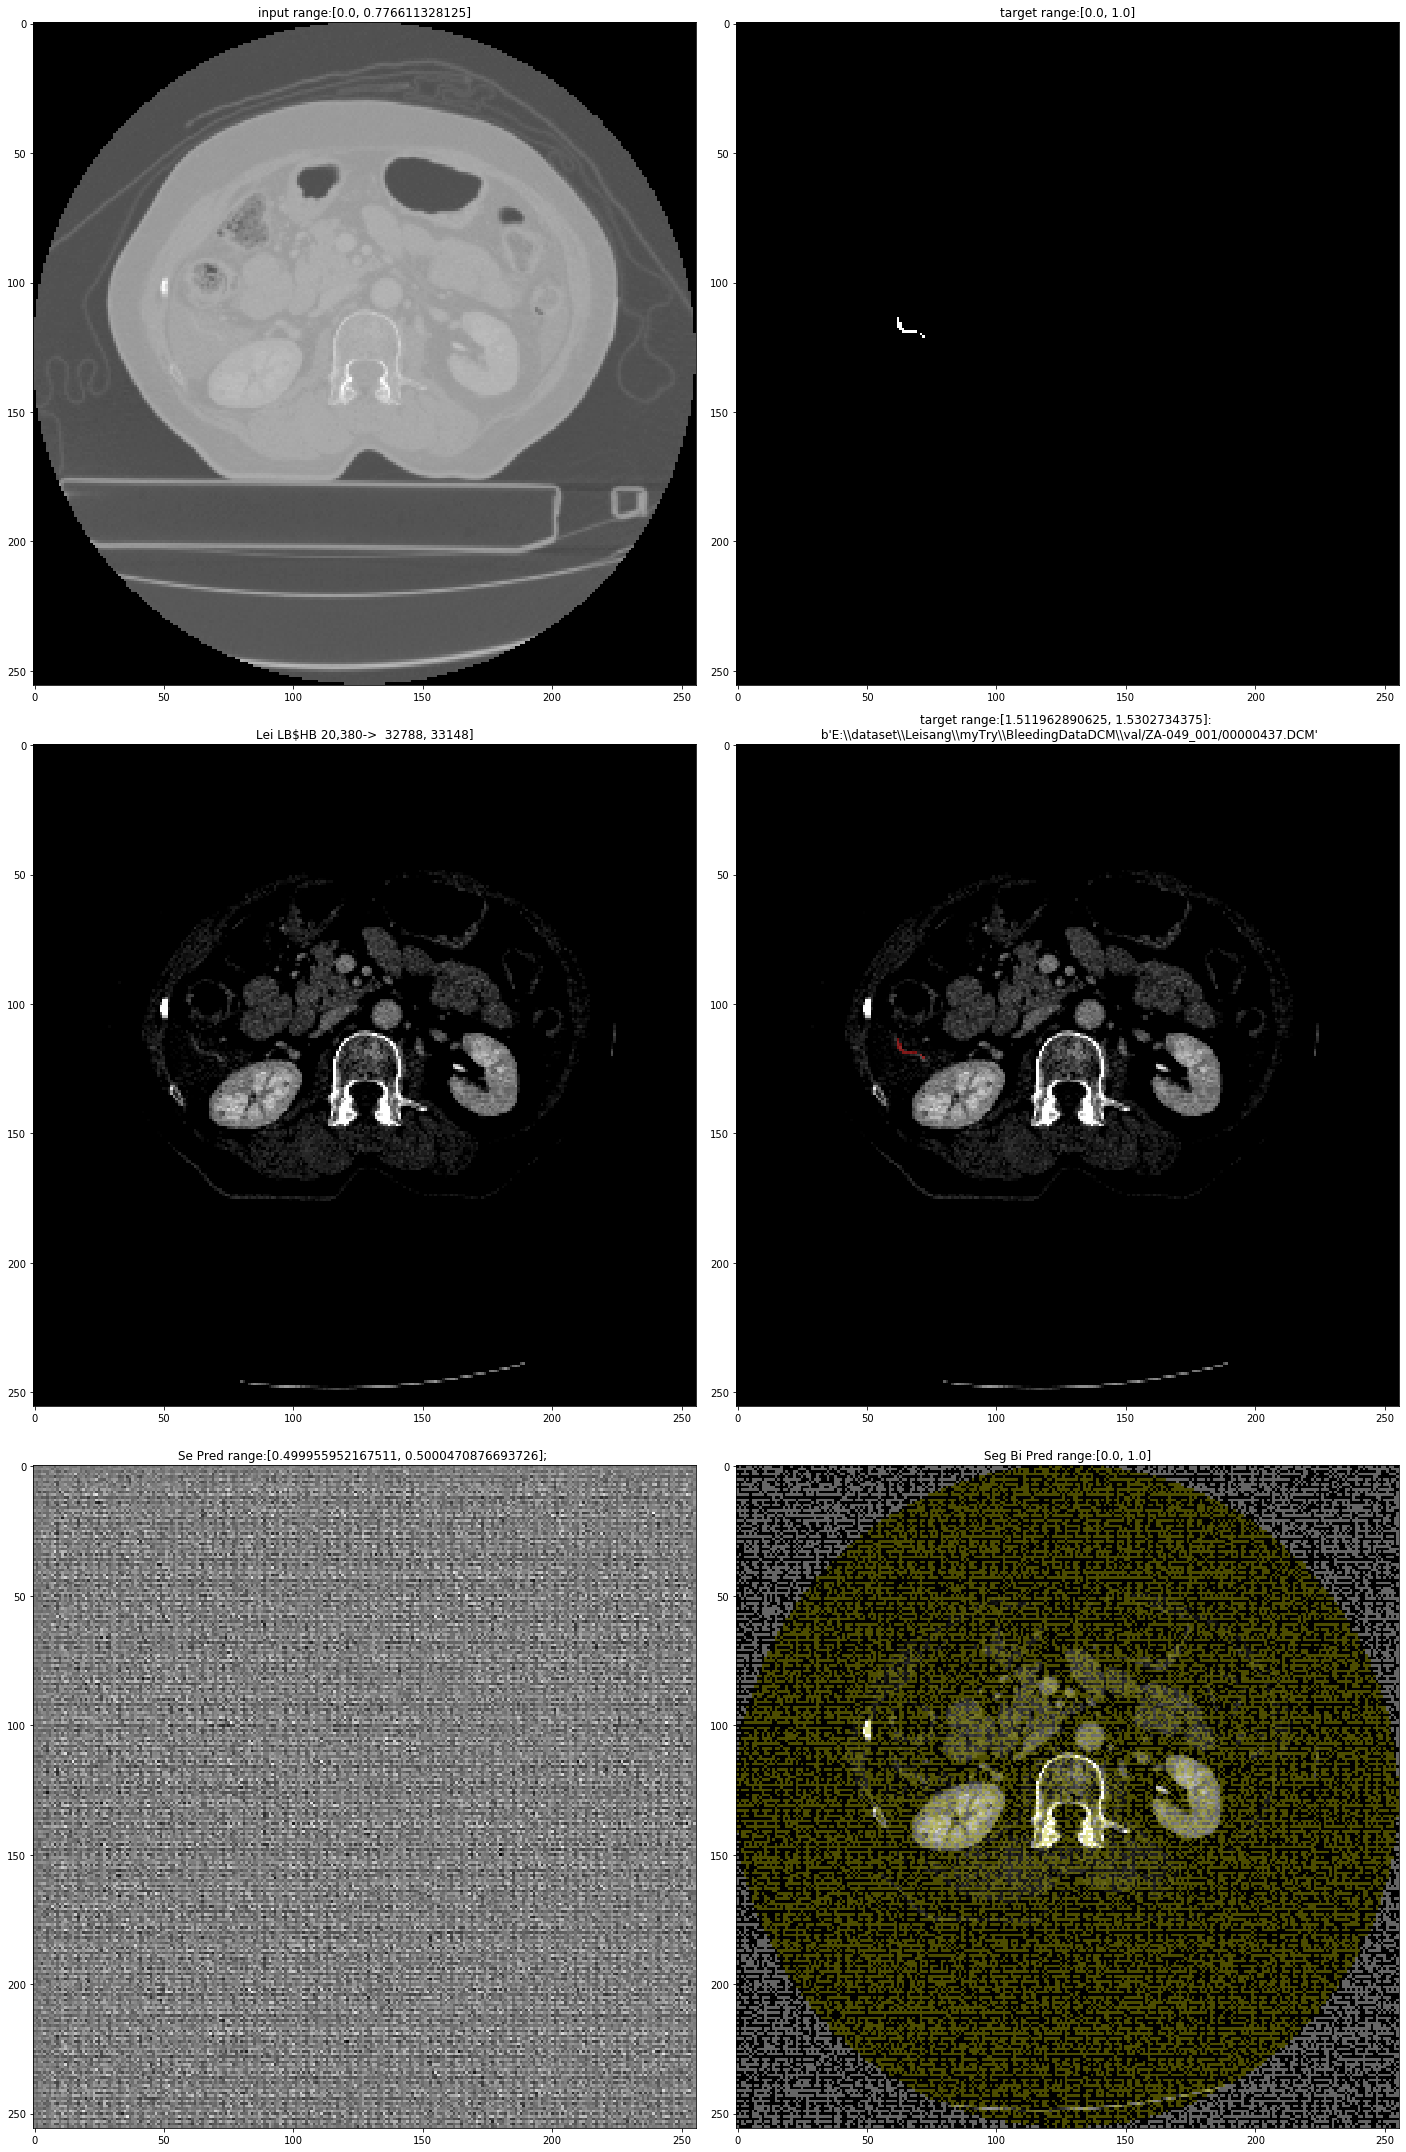

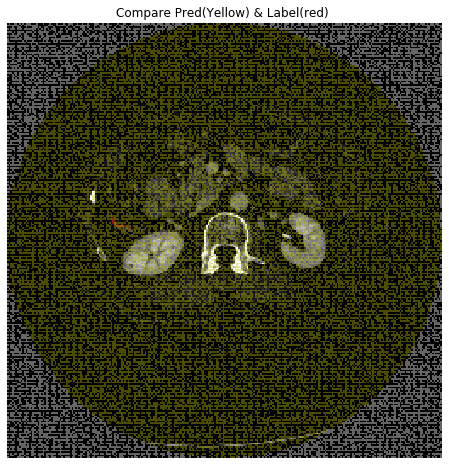

True
after reset basemodel trainable property: True


In [28]:
base_model =  en # use encoder as the base model

# check the loaded ae output
for image_features in test_dataset.take(2):
    dicom_path =  image_features[0]
    norm_input_w_image =  image_features[1]
    norm_input =  image_features[2]
    #     dicom_path = image_features[0].numpy()
    norm_target = image_features[3]
    cls_label = image_features[4]
    print("dicom_path:", dicom_path)
    print("input_image.shape", norm_input.shape)
    print("seg_label", norm_target.shape)
    print("cls_label", cls_label)

    
    # check the loaded encoder and decoder: encoder,decoder, norm_input, norm_input_w_image, norm_target, path, batch_idx, epoch, save=True
    en_de_generate_images(base_model, de,norm_input, norm_input_w_image,norm_target, dicom_path)

# check the base base model traininable
print(base_model.trainable)

# 
trainable_or_not =  True

if trainable_or_not == True:
    base_model.trainable =  True # set encoder untranable
print("after reset basemodel trainable property:", base_model.trainable)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 50)                6553

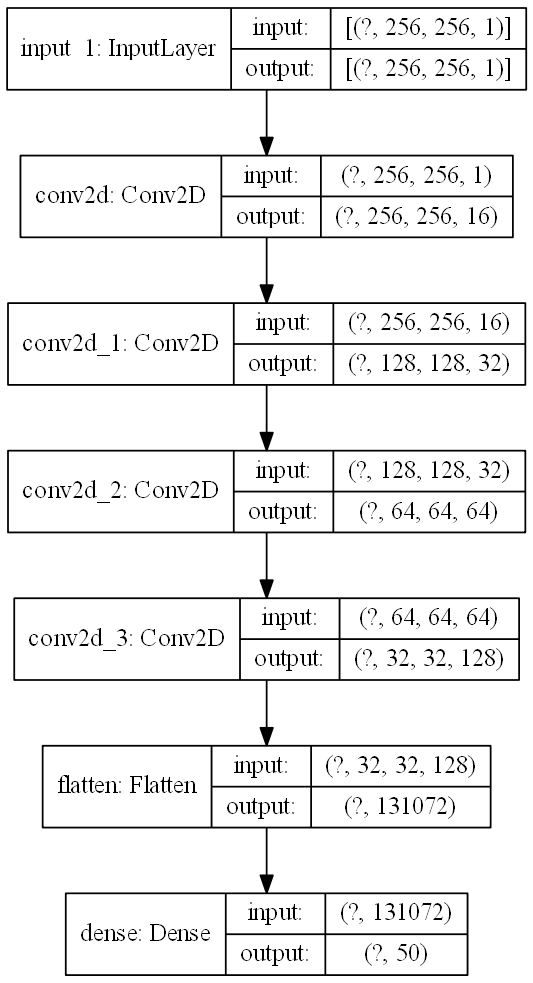

In [29]:
# check the trainable model architecture
base_model.summary()
tf.keras.utils.plot_model(base_model, to_file=base_model_path, show_shapes=True, dpi=128)

# of layers in the base_model: 7
Tensor("dense/Identity:0", shape=(None, 50), dtype=float32)
Tensor("dense/Identity:0", shape=(None, 50), dtype=float32)
Model: "classifier_head"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (

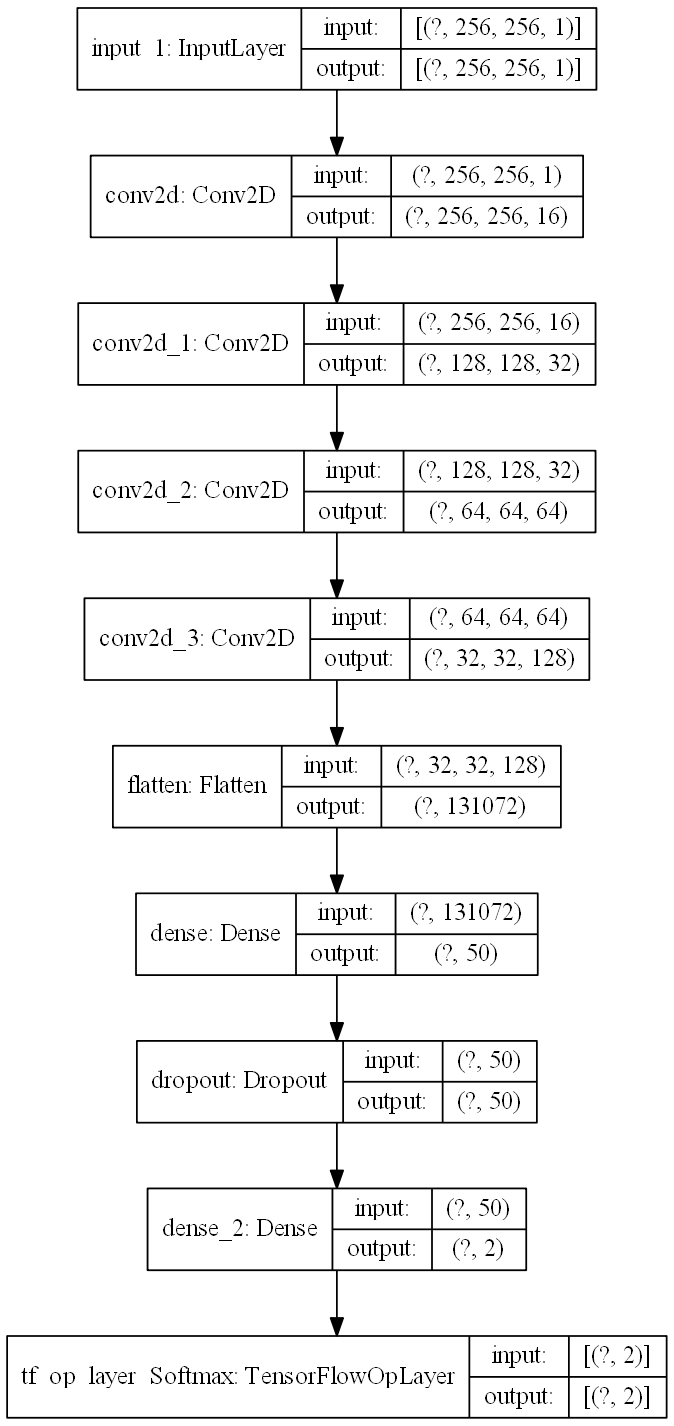

In [30]:
# add classification head for bleed exist or not
print("# of layers in the base_model:", len(base_model.layers))

class_dropout = tf.keras.layers.Dropout(0.5)(base_model.layers[-1].output)
class_head_nodes = tf.keras.layers.Dense(2)(class_dropout)
class_softmax_output =  tf.nn.softmax(class_head_nodes)
print(base_model.output)
print(base_model.layers[-1].output)
Classifier =  tf.keras.Model(inputs=en_inputs, outputs=class_softmax_output, name='classifier_head')
# check the architecture
Classifier.summary()
tf.keras.utils.plot_model(Classifier, to_file=classifier_path, show_shapes=True, dpi=128)

Tensor("conv2d_3/Identity:0", shape=(None, 32, 32, 128), dtype=float32)
Tensor("sequential_2/Identity:0", shape=(None, 32, 32, 256), dtype=float32)
Tensor("concatenate/Identity:0", shape=(None, 32, 32, 384), dtype=float32)
one more step encoding: Tensor("sequential_3/Identity:0", shape=(None, 16, 16, 512), dtype=float32)
GA: Tensor("global_average_pooling2d/Identity:0", shape=(None, 512), dtype=float32)
RESHAPE_GA: Tensor("Reshape_1:0", shape=(None, 1, 1, 512), dtype=float32)
resized GA: Tensor("resize/ResizeBilinear:0", shape=(None, 16, 16, 512), dtype=float32)
bottom_concate: Tensor("concatenate_1/Identity:0", shape=(None, 16, 16, 1024), dtype=float32)

start to upsample--------->
up_feature1: Tensor("sequential_4/Identity:0", shape=(None, 32, 32, 512), dtype=float32)
up_concate1: Tensor("concatenate_2/Identity:0", shape=(None, 32, 32, 768), dtype=float32)
up_feature2: Tensor("sequential_5/Identity:0", shape=(None, 64, 64, 256), dtype=float32)
up_concate2: Tensor("concatenate_3/Ident

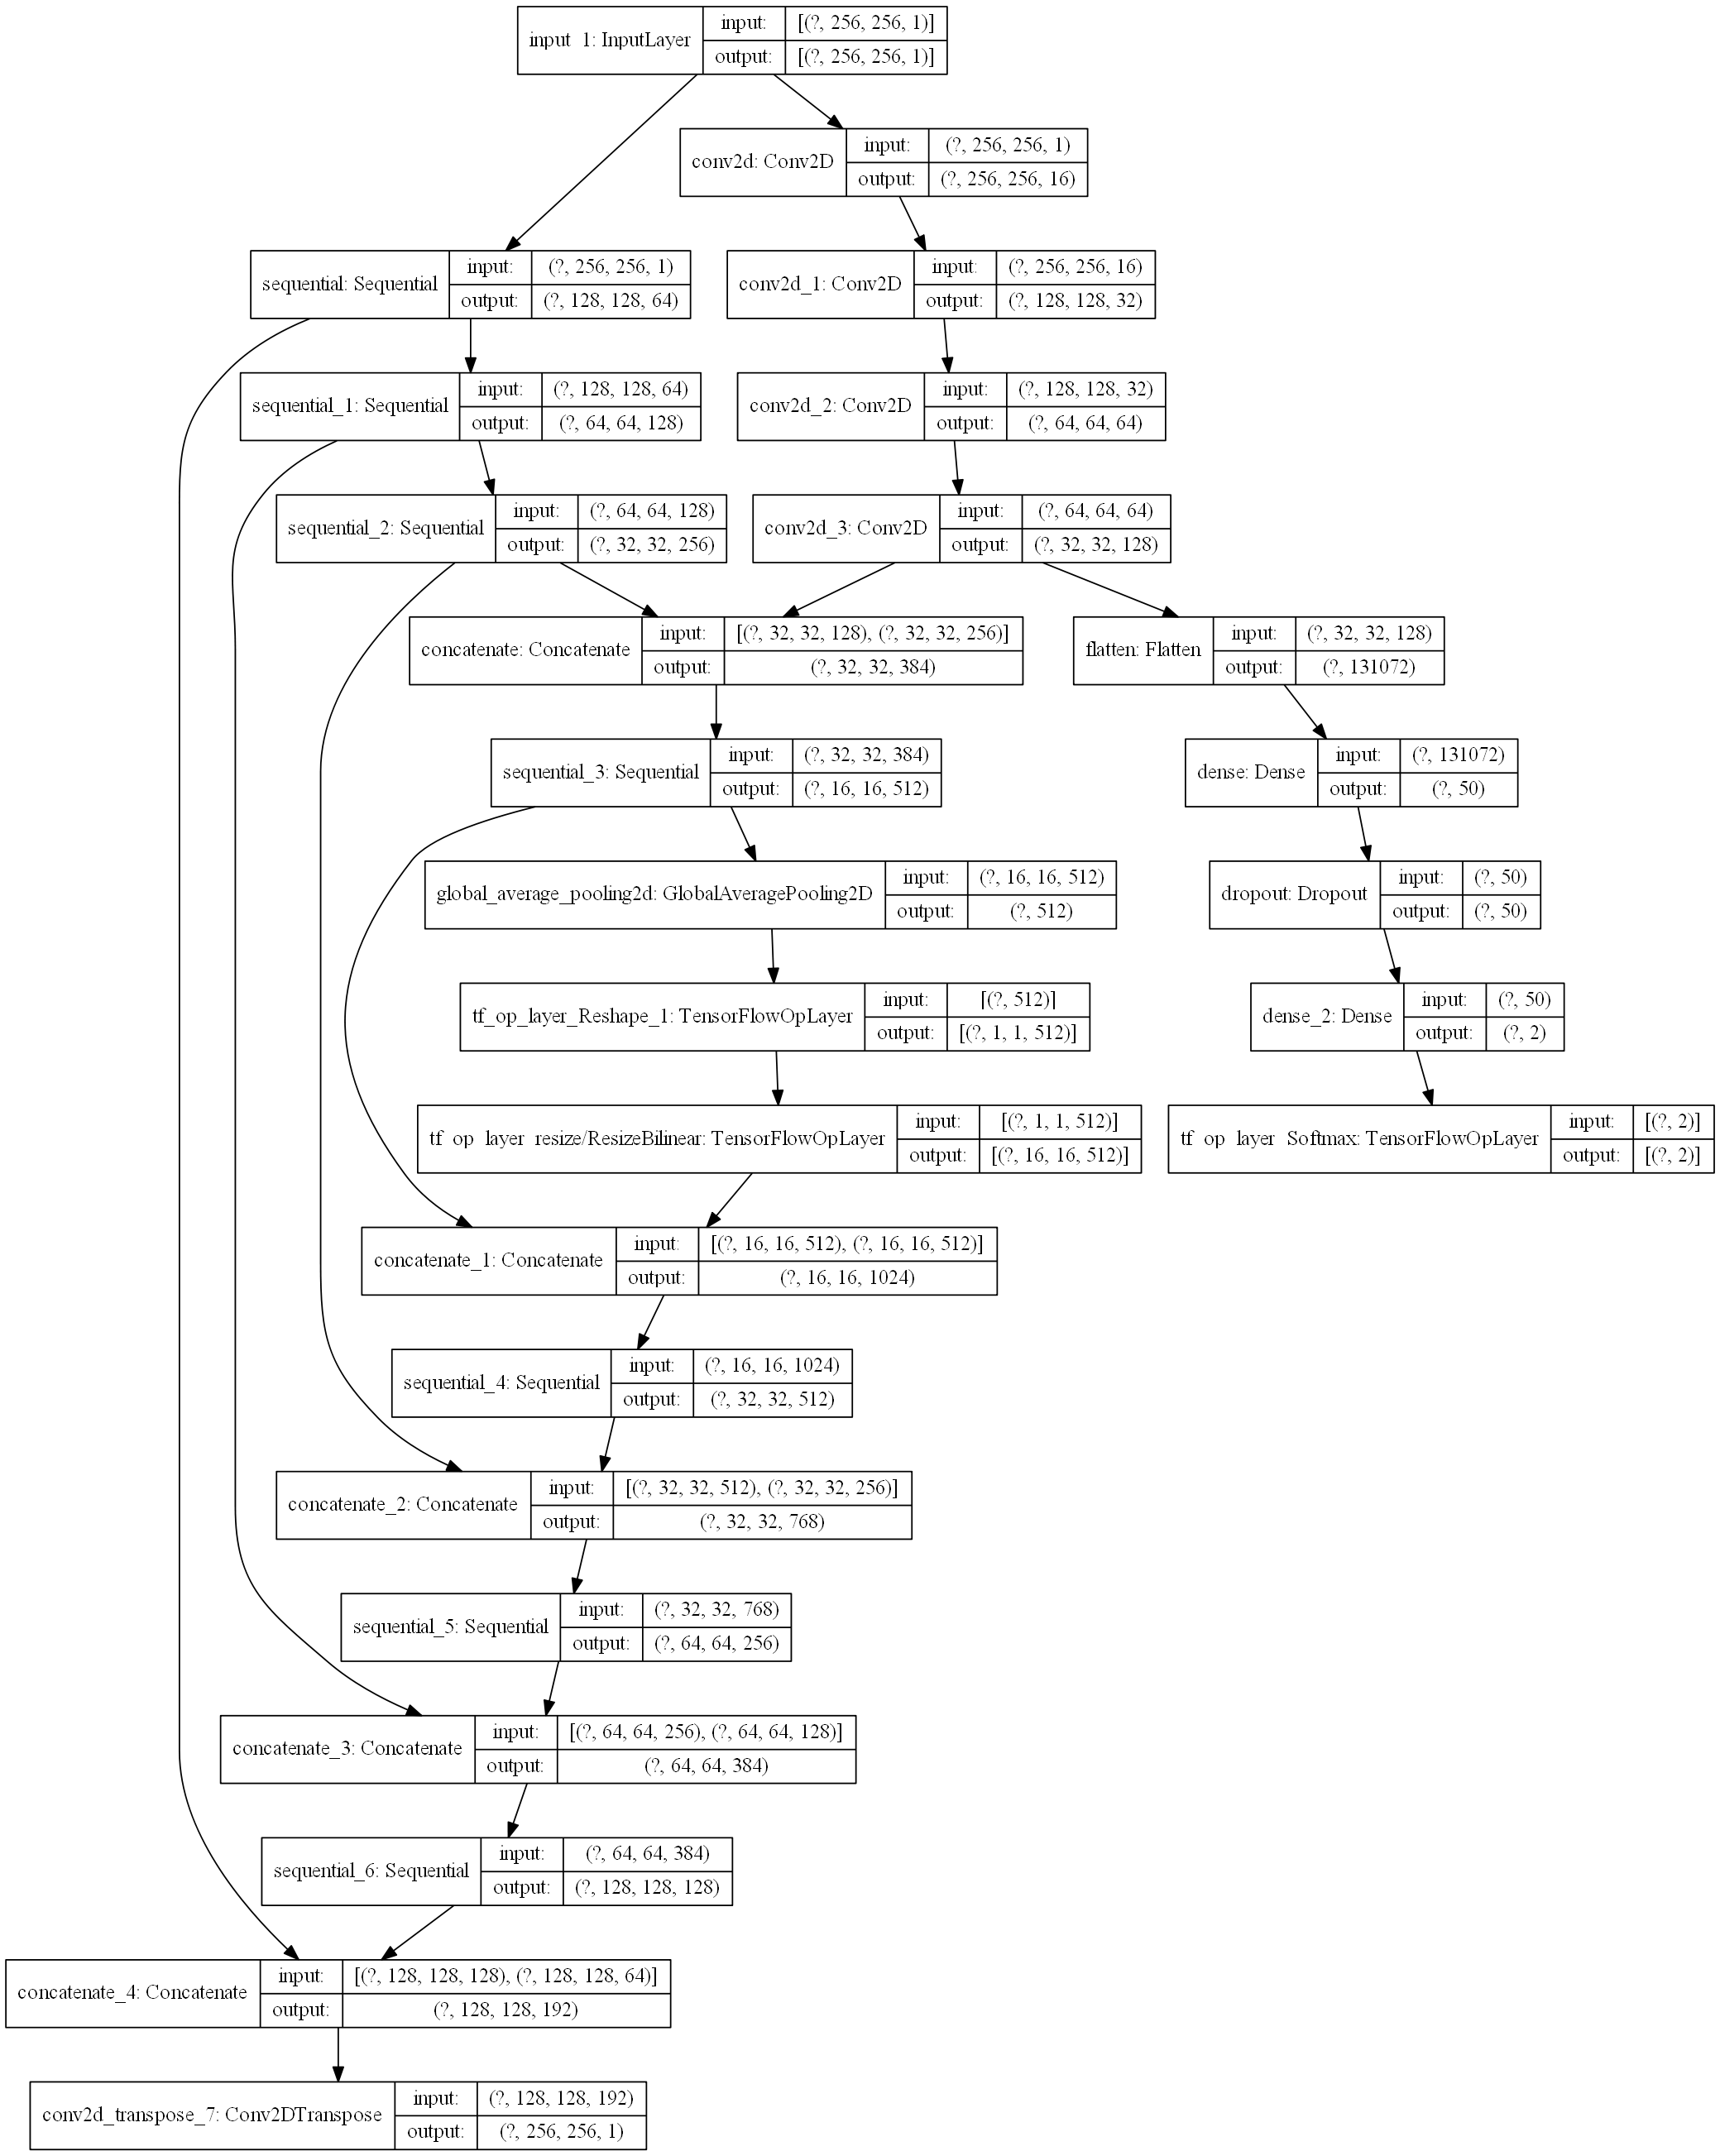

In [31]:
# set THE SETMENTATION PART
# 1st take out the feature from the base_model
base_feature =  base_model.layers[-3].output
print(base_feature)


# define down_sample block as the pix-2-pix from tensorflow official set
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result


# def skips needed to be connected
skips = []

def en_for_seg():
# new another path for the segmentation of the new model
    x = downsample(64, 4, apply_batchnorm=False)(en_inputs) # output  (None, 128, 128, 64)
    skips.append(x)
    x = downsample(128, 4)(x)  # output (None, 64, 64, 128)
    skips.append(x)
    x = downsample(256, 4)(x)  # output (None, 32, 32, 256)
    skips.append(x)
    # if want seperate train the generator, return the Model object e.g. return tf.keras.Model(inputs=inputs, outputs=x)
    return tf.keras.Model(inputs=en_inputs, outputs=x)

en_coder_for_seg_out =  en_for_seg()
print(en_coder_for_seg_out.output)
tf.keras.utils.plot_model(en_coder_for_seg_out, to_file="encodre_for_seg.png", show_shapes=True, dpi=128)





# concatenate the feature from base and feature from the new enocoder
concate_features =  tf.keras.layers.Concatenate()([base_feature, en_coder_for_seg_out.output])
print(concate_features)

# start to one more step to encoder
further_en = downsample(512, 4)(concate_features)  # output (None, 16, 16, 512)
print("one more step encoding:",further_en)

# global pooling for that one more step encoding fetures
GA  = tf.keras.layers.GlobalAveragePooling2D()(further_en)  # squeeze
print("GA:", GA)
# RESHAPE GA  TO THE IMAGE FORMMAT
RESHAPE_GA =  tf.reshape(GA, [-1,1,1, GA.shape[-1]])
print("RESHAPE_GA:", RESHAPE_GA)
#resize to the feature maps size
resize_GA =  tf.image.resize(RESHAPE_GA, (further_en.shape[1], further_en.shape[2]))
print("resized GA:", resize_GA)
# concate future_en and reisze_GA
bottom_concate =  tf.keras.layers.Concatenate()([resize_GA, further_en])
print("bottom_concate:", bottom_concate)

print()
print("start to upsample--------->")
# start to upsample and decoder from resize_GA and further_en
up_feature1 =  upsample(512, 4) (bottom_concate) #  upsample/relarge ti [None, 32, 32, 1024] without dropout default false for drop
print("up_feature1:", up_feature1)
up_concate1 =  tf.keras.layers.Concatenate()([up_feature1, skips[-1]])
print("up_concate1:", up_concate1)
up_feature2 =  upsample(256, 4) (up_concate1) #  upsample/relarge ti [None, 64, 64, 256] without dropout default false for drop
print("up_feature2:", up_feature2)
up_concate2 =  tf.keras.layers.Concatenate()([up_feature2, skips[-2]])
print("up_concate2:", up_concate2)
up_feature3 =  upsample(128, 4) (up_concate2) #  upsample/relarge ti [None, 128, 128, 128] without dropout default false for drop
print("up_feature3:", up_feature2)
up_concate3 =  tf.keras.layers.Concatenate()([up_feature3, skips[-3]])
print("up_concate3:", up_concate3)

# last layer output
initializer = tf.random_normal_initializer(0., 0.02)
last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2, # stride 2
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='sigmoid') # (bs, 256, 256, 3)
seg_out  =  last(up_concate3)

Final_seg_model = tf.keras.Model(inputs=en_inputs, outputs=[seg_out, class_softmax_output])
tf.keras.utils.plot_model(Final_seg_model, to_file=new_model_path, show_shapes=True, dpi=128)

dicom_path: tf.Tensor(
[b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000435.DCM'
 b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000436.DCM'], shape=(2,), dtype=string)
input_image.shape (2, 256, 256, 1)
seg_label (2, 256, 256, 1)
cls_label tf.Tensor([1 1], shape=(2,), dtype=int64)
output1 shape: (2, 256, 256, 1)
output2 shape: (2, 2)
dicom_path: tf.Tensor(
[b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000437.DCM'
 b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000438.DCM'], shape=(2,), dtype=string)
input_image.shape (2, 256, 256, 1)
seg_label (2, 256, 256, 1)
cls_label tf.Tensor([1 1], shape=(2,), dtype=int64)
output1 shape: (2, 256, 256, 1)
output2 shape: (2, 2)


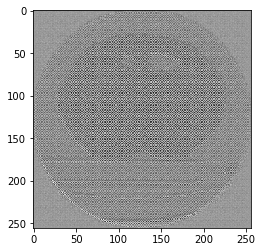

In [32]:
# check new model
# check the AE OUTPUT
# print("inp.shape:", cliped_norm_input.shape)
# print("inp[tf.newaxis,...]:", cliped_norm_input[tf.newaxis,...].shape)
# AE_output = autoencoder(resized_input[tf.newaxis,...], training=False)  # inp is the image sample from cell code 6 ; 
# print(AE_output.shape)
# plt.imshow(np.squeeze(AE_output[0,...]), cmap="gray")

# check the loaded ae output
for image_features in test_dataset.take(2):
    dicom_path =  image_features[0]
    norm_input_w_image =  image_features[1]
    norm_input =  image_features[2]
    #     dicom_path = image_features[0].numpy()
    norm_target = image_features[3]
    cls_label = image_features[4]
    print("dicom_path:", dicom_path)
    print("input_image.shape", norm_input.shape)
    print("seg_label", norm_target.shape)
    print("cls_label", cls_label)

 
    
    new_model_output =  Final_seg_model(norm_input)
    # outputs=[seg_out, class_sigmoid_output]
    output1=   new_model_output[0]
    output2=   new_model_output[1]
    print("output1 shape:", output1.shape)  
    print("output2 shape:", output2.shape)  
#     test_total_loss, test_BCE_loss, test_Huber_loss = test_step(AE, TEST_input, TEST_target, epoch) 
#     generate_images(AE, TEST_input, TEST_target,TEST_dicom_path,test_total_loss.numpy(), int(step), int(epoch), save=False)
    plt.imshow(np.squeeze(output1[0,...]), cmap="gray")
#     # check the loaded encoder and decoder
#     en_de_generate_images(en, de,TEST_input, TEST_target,TEST_dicom_path, int(step), int(epoch), save=False)

In [33]:
# design new loss for the new model as new_train_step, new_test_step
new_optimizer =  tf.keras.optimizers.Adam(1e-4)
# from tf.keras.utils import to_categorical
BCE =  tf.keras.losses.BinaryCrossentropy() 
Huber =  tf.keras.losses.Huber(delta=0.1)
SCE = tf.keras.losses.SparseCategoricalCrossentropy()
@tf.function()
# define losses
def new_compute_loss(pred_seg, gt_seg, pred_cls, gt_cls):
    
    #seg  cross_entropy,  use reduce mean not sum, otherwise loss will be very big
    seg_BCE_loss = BCE(y_true=gt_seg, y_pred=pred_seg) 
    
    
    # L1 loss 
#     L1_loss = tf.reduce_mean(tf.abs(x - decoded_x))
    
    #seg Huber_loss
    seg_Huber_loss = Huber(y_true=gt_seg, y_pred=pred_seg)
    
    seg_total_loss = seg_Huber_loss + seg_BCE_loss
    
    
    # use tf.keras.losses.SparseCategoricalCrossentropy instead of BCE , no need one-hot tranfermat
    cls_SCE_loss=  SCE(y_true=gt_cls, y_pred=pred_cls)
    
    # total_loss = cls_BCE_loss + seg_loss
    total_loss = cls_SCE_loss + seg_total_loss
    return total_loss, cls_SCE_loss, seg_total_loss
    

# def mask_to_categorical(cls_tar, num_cls=2):
#     tar = tf.one_hot(tf.cast(cls_tar, tf.int32), num_cls)
#     tar = tf.cast(tar, tf.float32)
#     return tar

@tf.function()
def new_train_step(model, input, seg_target, cls_target,epoch, training):
    # change cls labe 0 or 1 into  [1, 0] [0, 1]
    print(cls_target)
#     cls_target = mask_to_categorical(cls_target)
#     print("in trianing step")
    with tf.GradientTape() as tape:  # very interesting
        # outputs=[seg_out, class_sigmoid_output] 
        seg_out, class_softmax_output= model(input, training=training)
        total_loss, cls_SCE_loss, seg_total_loss = new_compute_loss(pred_seg=seg_out,
                                                            gt_seg=seg_target, 
                                                            pred_cls=class_softmax_output, 
                                                            gt_cls=cls_target)
    gradients = tape.gradient(total_loss, model.trainable_variables)
    new_optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss, cls_SCE_loss, seg_total_loss

@tf.function()
def new_test_step(model2, input2, seg_target2, cls_target2, epoch2, training2):
    with tf.GradientTape() as tape:  # very interesting
        seg_out2, class_softmax_output2= model2(input2, training=training2)
        total_loss2, cls_SCE_loss2, seg_total_loss2 = new_compute_loss(pred_seg=seg_out2,
                                                            gt_seg=seg_target2, 
                                                            pred_cls=class_softmax_output2, 
                                                            gt_cls=cls_target2)
    return total_loss2, cls_SCE_loss2, seg_total_loss2

## Confusion matrix define


In [34]:
!pip install scikit-learn
import sklearn.metrics
import itertools
def plot_confusion_matrix(cm, class_names, epoch, batch_indx, save=True):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes e.g, ["dog", "cat"]
    """
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix(range[{}, {}])".format(cm.min(), cm.max()))
    
     # Normalize the confusion matrix.
    norm_cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
     # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, "{}({})".format(cm[i, j],norm_cm[i, j]), horizontalalignment="center", color=color)
    plt.colorbar()  # rember the jupyter lab will remember the plt color operation so the coloar may related to the normalized value if not clean 
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names, rotation=45)

#     # Normalize the confusion matrix.
#     cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

#     # Use white text if squares are dark; otherwise black.
#     threshold = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         color = "white" if cm[i, j] > threshold else "black"
#         plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label', labelpad=0)
    plt.xlabel('Predicted label')
    if save:    
        plt.savefig(test_confusion_matrix + "/Test_cm_at_epoch_{:04d}_batch_{}.png".format(epoch,batch_indx))
    else:
        pass
    return figure

# define confusion matrix for classification displaying
def log_confusion_matrix_all(model,test_inputs, class_names,cls_tar, epoch, batch_indx, save):
    # Use the model to predict the values from the validation dataset.
    seg_out, class_softmax_output = model.predict(test_inputs)
    test_pred = np.argmax(class_softmax_output, axis=1)

    # Calculate the confusion matrix.
    cm = sklearn.metrics.confusion_matrix(cls_tar, test_pred)
    # Log the confusion matrix as an image summary.

    figure = plot_confusion_matrix(cm, class_names, epoch, batch_indx, save)
#     cm_image = plot_to_image(figure)


def return_cls_preds_tars(single_cls_pred, single_cls_tars):
    print("single_cls_pred:", single_cls_pred)
    print("single_cls_tars:", single_cls_tars)

# define confusion matrix for classification displaying
def log_confusion_matrix_without_model(cls_preds, class_names,cls_tars, epoch, batch_indx, save):
    # Use the model to predict the values from the validation dataset.
#     seg_out, class_softmax_output = model.predict(test_inputs)
    cls_preds_ints = np.argmax(cls_preds, axis=1)
    print("cls_preds_ints:", cls_preds_ints)
    print("cls_tars:", cls_tars)
    
    # Calculate the confusion matrix.
    cm = sklearn.metrics.confusion_matrix(cls_tars, cls_preds_ints)
    # Log the confusion matrix as an image summary.

    figure = plot_confusion_matrix(cm, class_names, epoch, batch_indx, save)
#     cm_image = plot_to_image(figure)

In [ ]:
import time


# build_new check point manager
new_ckpt_prefix = os.path.join(checkpoint_dir, "ckpt")
if not os.path.exists(new_ckpt_prefix):
    os.makedirs(new_ckpt_prefix)
#  contents of states to be saved as attributes on the checkpoint object
new_ckpt_ob = tf.train.Checkpoint(step= tf.Variable(1),
                                    epoch=  tf.Variable(1),
                                    optimizer=new_optimizer,
                                     new_model =  Final_seg_model
                                 )
# define checkpoint manager
new_manager =  tf.train.CheckpointManager(new_ckpt_ob, new_ckpt_prefix, max_to_keep=1)

# check the whether there is a checkpoint in the checkpoint folder, if it is restore from it
if new_manager.latest_checkpoint:
    print("Restored from {}".format(new_manager.latest_checkpoint))
    new_ckpt_ob.restore(new_manager.latest_checkpoint)
else:
    print("Initializing from scratch.")

# reset checkcpoint.step for each epoch
step =  new_ckpt_ob.step
ckpt_epoch =  new_ckpt_ob.epoch  

# test average_loss = for saving the test results
test_avg_tmp_loss = 100

for epoch in range(int(ckpt_epoch), epochs+1):
    train_total_loss_mean = tf.keras.metrics.Mean()
    train_seg_total_loss_mean = tf.keras.metrics.Mean()
    train_cls_SCE_loss_mean = tf.keras.metrics.Mean()
   
    
    # initial saving of checkpoints
#     if epoch == 1:
#         save_path =  manager.save()
#         print("Initial saving checkpoints at epoch {} batch {} at path {}".format(int(ckpt_epoch),  int(step) ,save_path))
       
        
    epoch_val_flag = False
    start_time =  time.time()
    cls_preds_entire = None
    cls_tar_entire = None
    for image_features0 in train_dataset:
        TR_dicom_path =  image_features0[0]
        TR_norm_input_w_image =  image_features0[1]
        TR_norm_input =  image_features0[2]
        #     dicom_path = image_features[0].numpy()
        TR_norm_target = image_features0[3]
        TR_cls_label = image_features0[4]
#     print("dicom_path:", dicom_path)
#     print("input_image.shape", norm_input.shape)
#     print("seg_label", norm_target.shape)
#     print("cls_label", cls_label)
        total_loss, cls_SCE_loss, seg_total_loss = new_train_step(Final_seg_model, TR_norm_input, TR_norm_target, TR_cls_label, epoch, training=True)
        end_time =  time.time()
        
        # calculate mean value for trainning losses
        train_total_loss_mean(total_loss)
        train_seg_total_loss_mean(seg_total_loss)
        train_cls_SCE_loss_mean(cls_SCE_loss)
        
#       

        if int(step) == 1:
            for image_features1 in test_dataset.take(1):
                TE_dicom_path1 =  image_features1[0]
                TE_norm_input_w_image1 =  image_features1[1]
                TE_norm_input1 =  image_features1[2]
                #     dicom_path = image_features[0].numpy()
                TE_norm_target1 = image_features1[3]
                TE_cls_label1 = image_features1[4]
#                 print("dicom_path:", dicom_path)
#                 print("input_image.shape", norm_input.shape)
#                 print("seg_label", norm_target.shape)
#                 print("cls_label", cls_label)
                new_generate_images(Final_seg_model, TE_norm_input1, TE_norm_input_w_image1, TE_norm_target1, TE_cls_label1, TE_dicom_path1,  int(step), epoch, save=True, Train_or_not=False)

                
   
    
                
        # every 100 batch step show the generate test image to check.
        if int(step) % 100 == 0:
            display.clear_output(wait=True)
            print("train image checking----------------------------------------------------------------------------------->")
            new_generate_images(Final_seg_model, TR_norm_input, TR_norm_input_w_image, TR_norm_target, TR_cls_label, TR_dicom_path,  int(step), epoch, save=True, Train_or_not=True)
            
            
            for image_features2 in test_dataset.take(1):
                TE_dicom_path2 =  image_features2[0]
                TE_norm_input_w_image2 =  image_features2[1]
                TE_norm_input2 =  image_features2[2]
                #     dicom_path = image_features[0].numpy()
                TE_norm_target2 = image_features2[3]
                TE_cls_label2 = image_features2[4]
#                 print("dicom_path:", dicom_path)
#                 print("input_image.shape", norm_input.shape)
#                 print("seg_label", norm_target.shape)
#                 print("cls_label", cls_label)
                print("test image checking----------------------------------------------------------------------------------->")
                new_generate_images(Final_seg_model, TE_norm_input2, TE_norm_input_w_image2, TE_norm_target2, TE_cls_label2, TE_dicom_path2,  int(step), epoch, save=True, Train_or_not=False)
                # every 400 steps save the genrate images
                
          
            print('Epoch{}: {}/{}: total_loss: {}; cls_SCE_loss: {}; seg_total_loss: {} '
          'time elapse {}'.format(int(ckpt_epoch), int(step), resampled_steps_per_epoch, total_loss, cls_SCE_loss, seg_total_loss, end_time-start_time))
                       
#         if step > 1:
#             break
        if step > resampled_steps_per_epoch:
            break
        else:
            step.assign_add(1)
        
    # print validation step
    if ckpt_epoch % 1 == 0:
        epoch_val_flag = True
        test_total_loss_mean = tf.keras.metrics.Mean()
        test_seg_total_loss_mean = tf.keras.metrics.Mean()
        test_cls_SCE_loss_mean = tf.keras.metrics.Mean()
        for  idx, image_features3 in enumerate(test_dataset):
            TE_dicom_path3 =  image_features3[0]
            TE_norm_input_w_image3 =  image_features3[1]
            TE_norm_input3 =  image_features3[2]
            #     dicom_path = image_features[0].numpy()
            TE_norm_target3 = image_features3[3]
            TE_cls_label3 = image_features3[4]
            # new_test_step(model, input, seg_target, cls_target, epoch)
            test_total_loss, test_cls_SCE_loss, test_seg_total_loss = new_test_step(Final_seg_model, TE_norm_input3, TE_norm_target3, TE_cls_label3, epoch, training2=False)
            test_total_loss_mean(test_total_loss)
            test_seg_total_loss_mean(test_seg_total_loss)
            test_cls_SCE_loss_mean(test_cls_SCE_loss)
            
            # save epoch validation image in the folder every 10 batches save
            
            if idx > n_positive_test_batches:  # when  evaluating negative val dataset using larger spacing
                if idx % 100 ==0:
                    new_generate_images(Final_seg_model, TE_norm_input3, TE_norm_input_w_image3, TE_norm_target3, TE_cls_label3, TE_dicom_path3,  idx, epoch, save=True, Train_or_not=False, Epoch_val=epoch_val_flag)
            else:
                new_generate_images(Final_seg_model, TE_norm_input3, TE_norm_input_w_image3, TE_norm_target3, TE_cls_label3, TE_dicom_path3,  idx, epoch, save=True, Train_or_not=False, Epoch_val=epoch_val_flag)                                               
            display.clear_output(wait=True)
            
             # Test input--------------batch input and targets to evaluate confusion matrix====================》
            _, cls_preds =Final_seg_model.predict(TE_norm_input3) # predicts has shape [batch size, len(classes)]
            print("single batch preds:", cls_preds.shape)
            if cls_preds_entire is None:
                cls_preds_entire = cls_preds
                cls_tar_entire = TE_cls_label3.numpy()
#                   
            else: 
                cls_preds_entire =  np.concatenate((cls_preds_entire, cls_preds), axis=0)
                cls_tar_entire = np.concatenate((cls_tar_entire, TE_cls_label3.numpy()), axis=0)
        print("preds_entire.shape", cls_preds_entire)
        print("cls_entire.shape", cls_tar_entire)   # https://www.tensorflow.org/tensorboard/image_summaries
#                 return_cls_preds_tars(single_cls_pred, single_cls_tars)
#             # check initial confusion matrix
        log_confusion_matrix_without_model(cls_preds=cls_preds_entire, class_names=["No bleed", "bleed"], cls_tars=cls_tar_entire, epoch=epoch, batch_indx=int(step), save=True)
        #
           
        print('Epoch: {}, Test total_loss set loss: {},  time elapse for current epoch {}'.format(int(ckpt_epoch),
                                                    test_total_loss_mean.result(),
                                                    end_time - start_time))
        
        epoch_val_flag = False # one epoch finish so set flag back
        
        with train_summary_writer.as_default():
            print("writing train logs to tensorboard...")                                                       
            # write scalars to the tensorboard after each train step
            tf.summary.scalar('total_loss', train_total_loss_mean.result(), step=epoch)
            tf.summary.scalar('seg_total_loss', train_seg_total_loss_mean.result(), step=epoch)
            tf.summary.scalar('cls_SCE_loss', train_cls_SCE_loss_mean.result(), step=epoch)
            
        with val_summary_writer.as_default():
            print("writing val logs to tensorboard...")                                                        
            # write scalars to the tensorboard after each train step
            tf.summary.scalar('total_loss', test_total_loss_mean.result(), step=epoch)
            tf.summary.scalar('seg_total_loss', test_seg_total_loss_mean.result(), step=epoch)
            tf.summary.scalar('cls_SCE_loss', test_cls_SCE_loss_mean.result(), step=epoch)
            
        if test_total_loss_mean.result() < test_avg_tmp_loss:
            save_path =  new_manager.save() # save the checkpoint and return the save path
            print("Saved checkpoint for epoch {}-  step {}: {}".format(int(ckpt_epoch), int(step), save_path))
            test_avg_tmp_loss =  test_total_loss_mean.result()
            
        
    ckpt_epoch.assign_add(1)     
    step.assign(1)

#     # saving (checkpoint) the model every 5 epochs
#     if epoch % 5 == 0:
#         print("saving checkpoints at epoch {}".format(epoch))
#         checkpoint.save(file_prefix = checkpoint_prefix)

print("training finished")   


single batch preds: (2, 2)
seg_out shape: (2, 256, 256, 1)
masked_in range:[0.0, 1.531494140625]
masked range:[1.51123046875, 1.531494140625]
norm_input_w_image.shape: (256, 256, 1)
mask2 shape: (256, 256)
masked_in2 shape: (256, 256)
masked_in range:[0.0, 0.833984375]
masked range:[0.0, 0.0]
